# SWB Regression Pipeline - Beta Power 
- Single Electrode Trial Averaged Regressions with Permutation Statistics
- Robust regression bdi ~ cpe regression coefficients for each ROI 
- ROI split mixed effects regressions (currently depreciated)

Created: 07/30/24 \
Updated: 09/15/2024 \
*ran with new regression dfs from 09/15/2024*

In [3]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm
import patsy
from statsmodels.api import OLS
from scipy import stats
from tqdm import tqdm
from sklearn.linear_model import RANSACRegressor, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


import warnings
warnings.filterwarnings('ignore')




In [4]:
%load_ext autoreload
%autoreload 2



In [58]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/'
anat_dir   = f'{base_dir}recon_labels/'
neural_dir = f'{base_dir}data/'
save_dir   = f'{base_dir}results/regression_data/'
fig_dir    = f'{base_dir}figs/regression_figs/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'


date = datetime.date.today().strftime('%m%d%Y')
print(date)



09152024


In [6]:
import sys
sys.path.append(f'{base_dir}LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *
from plot_tools import *



In [93]:
subj_ids = list(pd.read_excel(f'{base_dir}/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


In [94]:
bdi_list = pd.read_excel(f'{base_dir}/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df



subj_id  bdi
0    MS002   14
1    MS003    8
2    MS009   16
3    MS011   13
4    MS015   26
5    MS016   10
6    MS017   26
7    MS019   12
8    MS022   10
9    MS024   16
10   MS025   10
11   MS026    9
12   MS027   22
13   MS028   13
14   MS029   32
15   MS030   19
16   MS033   39
17   MS035   15
18   MS041   10
19   MS043   23
20   MS048   19
21   MS050    9
22     DA8   13
23   DA023   14
24   DA026   19
25   DA037    4
26   DA039   22

In [ ]:
# #### set theme for all plots
# # %matplotlib inline
# # from matplotlib import rc
# # rc('text', usetex=False)

# sns.set_theme(style='ticks') 
# sns.set_context("poster")



In [ ]:
# from matplotlib.colors import ListedColormap,LinearSegmentedColormap
# import matplotlib as mpl
# from matplotlib import cm


# # saez_cmap colors = org,yellow, sagegreen, darker green, blue, purple 

# # 671351
# saez_colors    = ['#ffb243','#FCE27C','#6a9752','#1d5d2a','#00467e','#561C46']
# saez_hex_cmap  = ListedColormap(saez_colors)
# saez_rgb       = [mpl.colors.to_rgb(hex) for hex in saez_colors]
# saez_full_cmap = LinearSegmentedColormap.from_list('saez_full_cmap',saez_rgb,N=10)
# #plot_palette = saez_linear_cmap.resampled(lutsize=30)
# expanded_cmap  = [mpl.colors.rgb2hex(saez_full_cmap(c)[:3]) for c in range(saez_full_cmap.N)]


# Load beta power data 

In [9]:
beta_df = pd.read_csv(f'{save_dir}beta_master_df.csv')
band = 'beta'
beta_df.subj_id.unique()



array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [43]:
beta_df.columns

Index(['Unnamed: 0', 'subj_id', 'bdi', 'bdi_thresh', 'Round', 'RT',
       'TrialOnset', 'ChoiceOnset', 'DecisionOnset', 'FeedbackOnset',
       'ChoicePos', 'TrialType', 'SafeBet', 'LowBet', 'HighBet',
       'GambleChoice', 'Outcome', 'Profit', 'TotalProfit', 'epoch', 'logRT',
       'GambleEV', 'TrialEV', 'CR', 'choiceEV', 'rpe', 'res_type', 'cf',
       'max_cf', 'cpe', 'max_cpe', 'Round_t1', 'RT_t1', 'ChoicePos_t1',
       'TrialType_t1', 'SafeBet_t1', 'LowBet_t1', 'HighBet_t1',
       'GambleChoice_t1', 'Outcome_t1', 'Profit_t1', 'TotalProfit_t1',
       'epoch_t1', 'logRT_t1', 'GambleEV_t1', 'TrialEV_t1', 'CR_t1',
       'choiceEV_t1', 'rpe_t1', 'res_type_t1', 'cf_t1', 'max_cf_t1', 'cpe_t1',
       'max_cpe_t1', 'keep_epoch', 'keep_epoch_t1', 'CpeOnset',
       'reref_ch_names', 'band_pow', 'roi', 'hemi', 'unique_reref_ch'],
      dtype='object')

In [10]:
roi_reref_labels_master_df = pd.read_csv(
    glob(f'{base_dir}results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [11]:
roi_reref_labels_master_df.roi.value_counts()



roi
dmpfc            225
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
temporal         105
vlpfc             82
ains              71
pins              60
thalamus          58
temporal pole     31
mcc               28
phg               25
motor             25
parietal          24
vmpfc             23
caudate            8
pcc                1
Name: count, dtype: int64

In [41]:
# #### filter df by rois with electrode counts >= 50 *** updated to >15
# keep_rois = roi_reref_labels_master_df.roi.value_counts().index[roi_reref_labels_master_df.roi.value_counts(
# ).values>=20].tolist()

# keep_rois = roi_reref_labels_master_df.roi.value_counts().index[
#     roi_reref_labels_master_df.roi.value_counts().values>=50].tolist()
keep_rois = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','amy','hpc']     
# keep_rois.del(['thalamus','sts','temporal'])
# keep_rois = keep_rois
keep_rois

['dlpfc', 'vlpfc', 'dmpfc', 'ofc', 'ains', 'pins', 'acc', 'amy', 'hpc']

In [42]:
# ####### NEW DATA FRAME 
beta_reg_df = beta_df.copy()
beta_reg_df = beta_reg_df[beta_reg_df.roi.isin(keep_rois)]
# len(beta_reg_df)



# Test Single Electrode Regressions 

In [61]:
elec_col    = 'unique_reref_ch'
main_var    = 'cpe'
reg_formula = 'band_pow~GambleChoice+TotalProfit+cpe'
n_permutations = 1000
results_dict, main_var_sig = run_individual_elec_regression(beta_reg_df,reg_formula,elec_col, 
                                                            main_var,n_permutations)

Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3027.26it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3066.11it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3143.47it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3039.78it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3039.73it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3013.95it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3001.06it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3016.65it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3002.50it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3029.15it/s]


In [62]:
save_vars = results_dict['MS002_lacas1-lacas2'].index.tolist()
save_vars


['Intercept', 'GambleChoice[T.safe]', 'TotalProfit', 'cpe']

In [63]:
results = single_elec_permutation_results(results_dict,beta_reg_df,save_vars)
results



unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
0     MS002_lacas1-lacas2   MS002    acc   14                     0.029826   
1     MS002_lacas2-lacas3   MS002    acc   14                    -0.009893   
2     MS002_lacas3-lacas4   MS002    acc   14                     0.010601   
3     MS002_lacas4-lacas5   MS002    acc   14                     0.002235   
4     MS002_lacas5-lacas6   MS002    acc   14                    -0.008823   
...                   ...     ...    ...  ...                          ...   
1183  DA039_rpins1-rpins2   DA039   pins   22                     0.005626   
1184  DA039_rpins2-rpins3   DA039   pins   22                     0.010778   
1185  DA039_rpins3-rpins4   DA039   pins   22                    -0.004765   
1186  DA039_rsgcc6-rsgcc7   DA039  vlpfc   22                    -0.055704   
1187  DA039_rsgcc7-rsgcc8   DA039  vlpfc   22                    -0.030216   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TotalProfit  \
0                                  -0.049535                       0.030265   
1                                   0.017386                       0.017175   
2                                  -0.015247                       0.010986   
3                                  -0.016110                      -0.006550   
4                                   0.018868                      -0.010411   
...                                      ...                            ...   
1183                               -0.006240                      -0.013385   
1184                                0.016025                      -0.012370   
1185                               -0.037426                      -0.051845   
1186                                0.008865                      -0.014133   
1187                               -0.015720                      -0.028435   

      Original_Estimate_cpe  Permuted_Mean_Intercept  \
0                  0.030789                -0.004460   
1                  0.039977                 0.001147   
2                  0.044279                 0.000463   
3                  0.040789                -0.008585   
4                 -0.004780                 0.004196   
...                     ...                      ...   
1183               0.021910                 0.003767   
1184               0.009655                 0.017357   
1185               0.041322                -0.018340   
1186               0.031492                -0.050876   
1187               0.073657                -0.034585   

      Permuted_Mean_GambleChoice[T.safe]  ...  Permuted_Std_TotalProfit  \
0                              -0.000151  ...                  0.021998   
1                               0.001310  ...                  0.024111   
2                              -0.000871  ...                  0.023353   
3                              -0.000822  ...                  0.020446   
4                               0.000085  ...                  0.021794   
...                                  ...  ...                       ...   
1183                           -0.000196  ...                  0.022853   
1184                            0.000441  ...                  0.026132   
1185                            0.000622  ...                  0.024809   
1186                           -0.001529  ...                  0.023122   
1187                           -0.000937  ...                  0.028466   

      Permuted_Std_cpe  Z_Score_Intercept  Z_Score_GambleChoice[T.safe]  \
0             0.020443           2.124872                     -2.123001   
1             0.025372          -0.607267                      0.613445   
2             0.023523           0.591272                     -0.581680   
3             0.019443           0.729748                     -0.715322   
4             0.020787          -0.827903                      0.828451   
...                ...                ...                           ...   
1183          0.022518    

In [64]:
results.columns



Index(['unique_elec_id', 'subj_id', 'roi', 'bdi',
       'Original_Estimate_Intercept', 'Original_Estimate_GambleChoice[T.safe]',
       'Original_Estimate_TotalProfit', 'Original_Estimate_cpe',
       'Permuted_Mean_Intercept', 'Permuted_Mean_GambleChoice[T.safe]',
       'Permuted_Mean_TotalProfit', 'Permuted_Mean_cpe',
       'Permuted_Std_Intercept', 'Permuted_Std_GambleChoice[T.safe]',
       'Permuted_Std_TotalProfit', 'Permuted_Std_cpe', 'Z_Score_Intercept',
       'Z_Score_GambleChoice[T.safe]', 'Z_Score_TotalProfit', 'Z_Score_cpe',
       'P_Value_Intercept', 'P_Value_GambleChoice[T.safe]',
       'P_Value_TotalProfit', 'P_Value_cpe'],
      dtype='object')

In [65]:
# # create a binary pickle file 
pickle.dump(results,
            open(f'{save_dir}single_elec_regression_{band}_{reg_formula}_{date}.pkl',"wb"))



In [68]:
sig_data = results[results.P_Value_cpe < 0.05]
sig_data



unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
3     MS002_lacas4-lacas5   MS002    acc   14                     0.002235   
12    MS002_laims1-laims2   MS002   ains   14                     0.072678   
15    MS002_laims4-laims5   MS002   ains   14                    -0.005958   
51    MS002_racas6-racas7   MS002  dmpfc   14                     0.086069   
52    MS002_racas7-racas8   MS002  dmpfc   14                     0.116155   
...                   ...     ...    ...  ...                          ...   
1137      DA026_lhh2-lhh3   DA026    hpc   19                    -0.060325   
1144  DA037_rmins1-rmins2   DA037   pins    4                    -0.017613   
1158  DA039_rains2-rains3   DA039   ains   22                     0.014269   
1182    DA039_rof11-rof12   DA039  dlpfc   22                    -0.029831   
1187  DA039_rsgcc7-rsgcc8   DA039  vlpfc   22                    -0.030216   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TotalProfit  \
3                                  -0.016110                      -0.006550   
12                                 -0.063177                       0.043974   
15                                  0.040393                       0.041763   
51                                 -0.076772                      -0.000564   
52                                 -0.115085                       0.011485   
...                                      ...                            ...   
1137                                0.024784                      -0.031141   
1144                                0.009476                      -0.002277   
1158                               -0.077720                      -0.052735   
1182                               -0.019614                       0.000800   
1187                               -0.015720                      -0.028435   

      Original_Estimate_cpe  Permuted_Mean_Intercept  \
3                  0.040789                -0.008585   
12                 0.059288                 0.027911   
15                 0.060306                 0.020636   
51                -0.051721                 0.033523   
52                -0.061028                 0.037024   
...                     ...                      ...   
1137              -0.071378                -0.046040   
1144               0.011084                -0.015401   
1158               0.065527                -0.015744   
1182               0.025811                -0.037575   
1187               0.073657                -0.034585   

      Permuted_Mean_GambleChoice[T.safe]  ...  Permuted_Std_TotalProfit  \
3                              -0.000822  ...                  0.020446   
12                              0.001212  ...                  0.029931   
15                              0.001914  ...                  0.027437   
51                             -0.000705  ...                  0.026697   
52                             -0.000558  ...                  0.029286   
...                                  ...  ...                       ...   
1137                           -0.000205  ...                  0.025737   
1144                           -0.000278  ...                  0.004014   
1158                            0.002361  ...                  0.034636   
1182                            0.000629  ...                  0.012489   
1187                           -0.000937  ...                  0.028466   

      Permuted_Std_cpe  Z_Score_Intercept  Z_Score_GambleChoice[T.safe]  \
3             0.019443           0.729748                     -0.715322   
12            0.029264           1.917177                     -1.913259   
15            0.027992          -1.303337                      1.308413   
51            0.026130           2.684118                     -2.695580   
52            0.028746           3.644684                     -3.658610   
...                ...                ...                           ...   
1137          0.024970    

In [70]:
sig_data.roi.value_counts()



roi
acc      21
dmpfc    17
ofc      16
dlpfc    14
ains     10
pins      7
vlpfc     6
hpc       6
amy       5
Name: count, dtype: int64

In [71]:
sig_data.roi.unique()



array(['acc', 'ains', 'dmpfc', 'amy', 'dlpfc', 'ofc', 'pins', 'vlpfc',
       'hpc'], dtype=object)

In [72]:
bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']


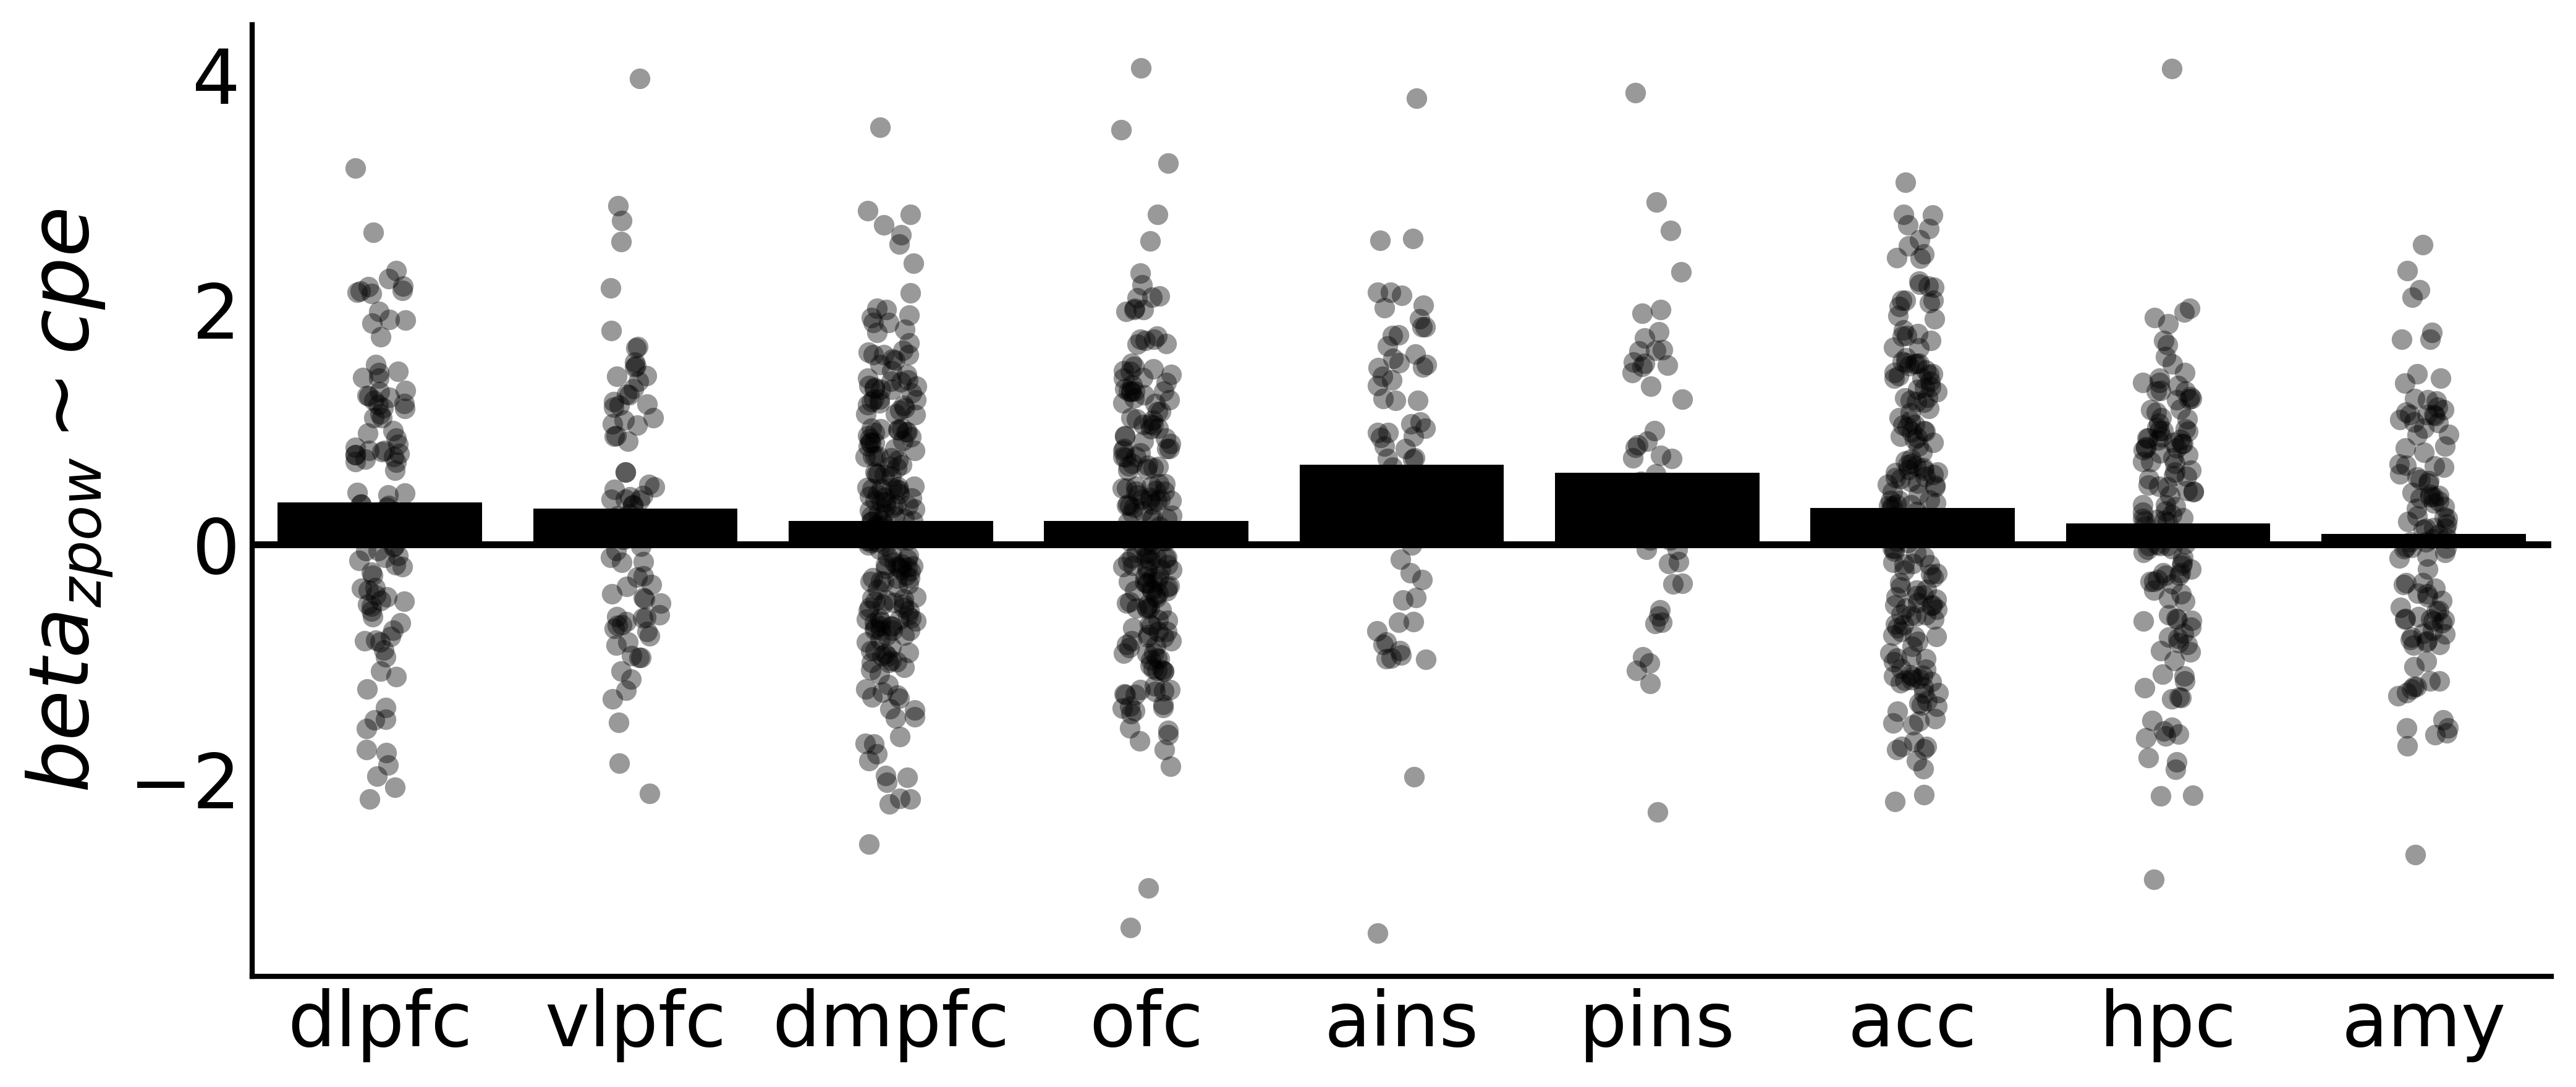

In [74]:
ylabel = fr'${band}_{{zpow}} \sim cpe$'
# fig_save_dir = '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/results/single-electrode-regressions/'
fig_id = f'{band}_single_elec_roi_barplot.pdf'


plot_roi_model_results(results,'roi','Z_Score_cpe',bar_order=bar_order,figsize=(12,5),color='k',
                       ylabel=ylabel,save_fig=True,save_dir=fig_dir,fig_id=fig_id,dpi=400)



In [76]:
results.to_csv(f'{save_dir}{band}_single_elec_perm_results.csv')

In [78]:
results.groupby('roi').agg('mean',numeric_only=True)['Z_Score_cpe'][bar_order]



roi
dlpfc    0.357645
vlpfc    0.306781
dmpfc    0.200404
ofc      0.197769
ains     0.675969
pins     0.608314
acc      0.311818
hpc      0.176221
amy      0.086859
Name: Z_Score_cpe, dtype: float64

In [79]:
single_elec_res = results.copy()[results.roi.isin(bar_order)]
single_elec_res


unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
0     MS002_lacas1-lacas2   MS002    acc   14                     0.029826   
1     MS002_lacas2-lacas3   MS002    acc   14                    -0.009893   
2     MS002_lacas3-lacas4   MS002    acc   14                     0.010601   
3     MS002_lacas4-lacas5   MS002    acc   14                     0.002235   
4     MS002_lacas5-lacas6   MS002    acc   14                    -0.008823   
...                   ...     ...    ...  ...                          ...   
1183  DA039_rpins1-rpins2   DA039   pins   22                     0.005626   
1184  DA039_rpins2-rpins3   DA039   pins   22                     0.010778   
1185  DA039_rpins3-rpins4   DA039   pins   22                    -0.004765   
1186  DA039_rsgcc6-rsgcc7   DA039  vlpfc   22                    -0.055704   
1187  DA039_rsgcc7-rsgcc8   DA039  vlpfc   22                    -0.030216   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TotalProfit  \
0                                  -0.049535                       0.030265   
1                                   0.017386                       0.017175   
2                                  -0.015247                       0.010986   
3                                  -0.016110                      -0.006550   
4                                   0.018868                      -0.010411   
...                                      ...                            ...   
1183                               -0.006240                      -0.013385   
1184                                0.016025                      -0.012370   
1185                               -0.037426                      -0.051845   
1186                                0.008865                      -0.014133   
1187                               -0.015720                      -0.028435   

      Original_Estimate_cpe  Permuted_Mean_Intercept  \
0                  0.030789                -0.004460   
1                  0.039977                 0.001147   
2                  0.044279                 0.000463   
3                  0.040789                -0.008585   
4                 -0.004780                 0.004196   
...                     ...                      ...   
1183               0.021910                 0.003767   
1184               0.009655                 0.017357   
1185               0.041322                -0.018340   
1186               0.031492                -0.050876   
1187               0.073657                -0.034585   

      Permuted_Mean_GambleChoice[T.safe]  ...  Permuted_Std_TotalProfit  \
0                              -0.000151  ...                  0.021998   
1                               0.001310  ...                  0.024111   
2                              -0.000871  ...                  0.023353   
3                              -0.000822  ...                  0.020446   
4                               0.000085  ...                  0.021794   
...                                  ...  ...                       ...   
1183                           -0.000196  ...                  0.022853   
1184                            0.000441  ...                  0.026132   
1185                            0.000622  ...                  0.024809   
1186                           -0.001529  ...                  0.023122   
1187                           -0.000937  ...                  0.028466   

      Permuted_Std_cpe  Z_Score_Intercept  Z_Score_GambleChoice[T.safe]  \
0             0.020443           2.124872                     -2.123001   
1             0.025372          -0.607267                      0.613445   
2             0.023523           0.591272                     -0.581680   
3             0.019443           0.729748                     -0.715322   
4             0.020787          -0.827903                      0.828451   
...                ...                ...                           ...   
1183          0.022518    

In [81]:

single_rho_data = []
single_sig_rho = []

# BDI CORRELATIONS
for roi in single_elec_res.roi.unique().tolist():
    roi_temp_data = single_elec_res[single_elec_res.roi==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.Z_Score_cpe)
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
#     fe_results['rho'][fe_results.roi==roi]   = rho
#     fe_results['rho_p'][fe_results.roi==roi] = rho_p
    
    single_rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':np.round(rho_p,4)},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
#     if rho_p < bonferr_alpha:


    if rho_p < 0.05:
        single_sig_rho.append((roi,rho,rho_p))
#     print(f'{roi} pearsonr',rho,rho_p)

single_rho_data = pd.concat(single_rho_data).reset_index(drop=True)




In [83]:
agg_single_results = single_elec_res.groupby('roi').agg('mean',numeric_only=True)[['Z_Score_cpe']].copy()

agg_single_results


Z_Score_cpe
roi               
acc       0.311818
ains      0.675969
amy       0.086859
dlpfc     0.357645
dmpfc     0.200404
hpc       0.176221
ofc       0.197769
pins      0.608314
vlpfc     0.306781

In [84]:
single_rho_data = single_rho_data.set_index('roi')
single_rho_data['Z_Score_cpe'] = agg_single_results.Z_Score_cpe
single_rho_data[['Z_Score_cpe','rho','rho_p']]



Z_Score_cpe       rho   rho_p
roi                                 
acc       0.311818 -0.128597  0.0747
dmpfc     0.200404 -0.008274  0.9018
amy       0.086859 -0.007022  0.9412
ains      0.675969 -0.330225  0.0049
vlpfc     0.306781 -0.296493  0.0068
hpc       0.176221 -0.108835  0.2089
ofc       0.197769 -0.185631  0.0082
pins      0.608314  0.067018  0.6109
dlpfc     0.357645 -0.244196  0.0113

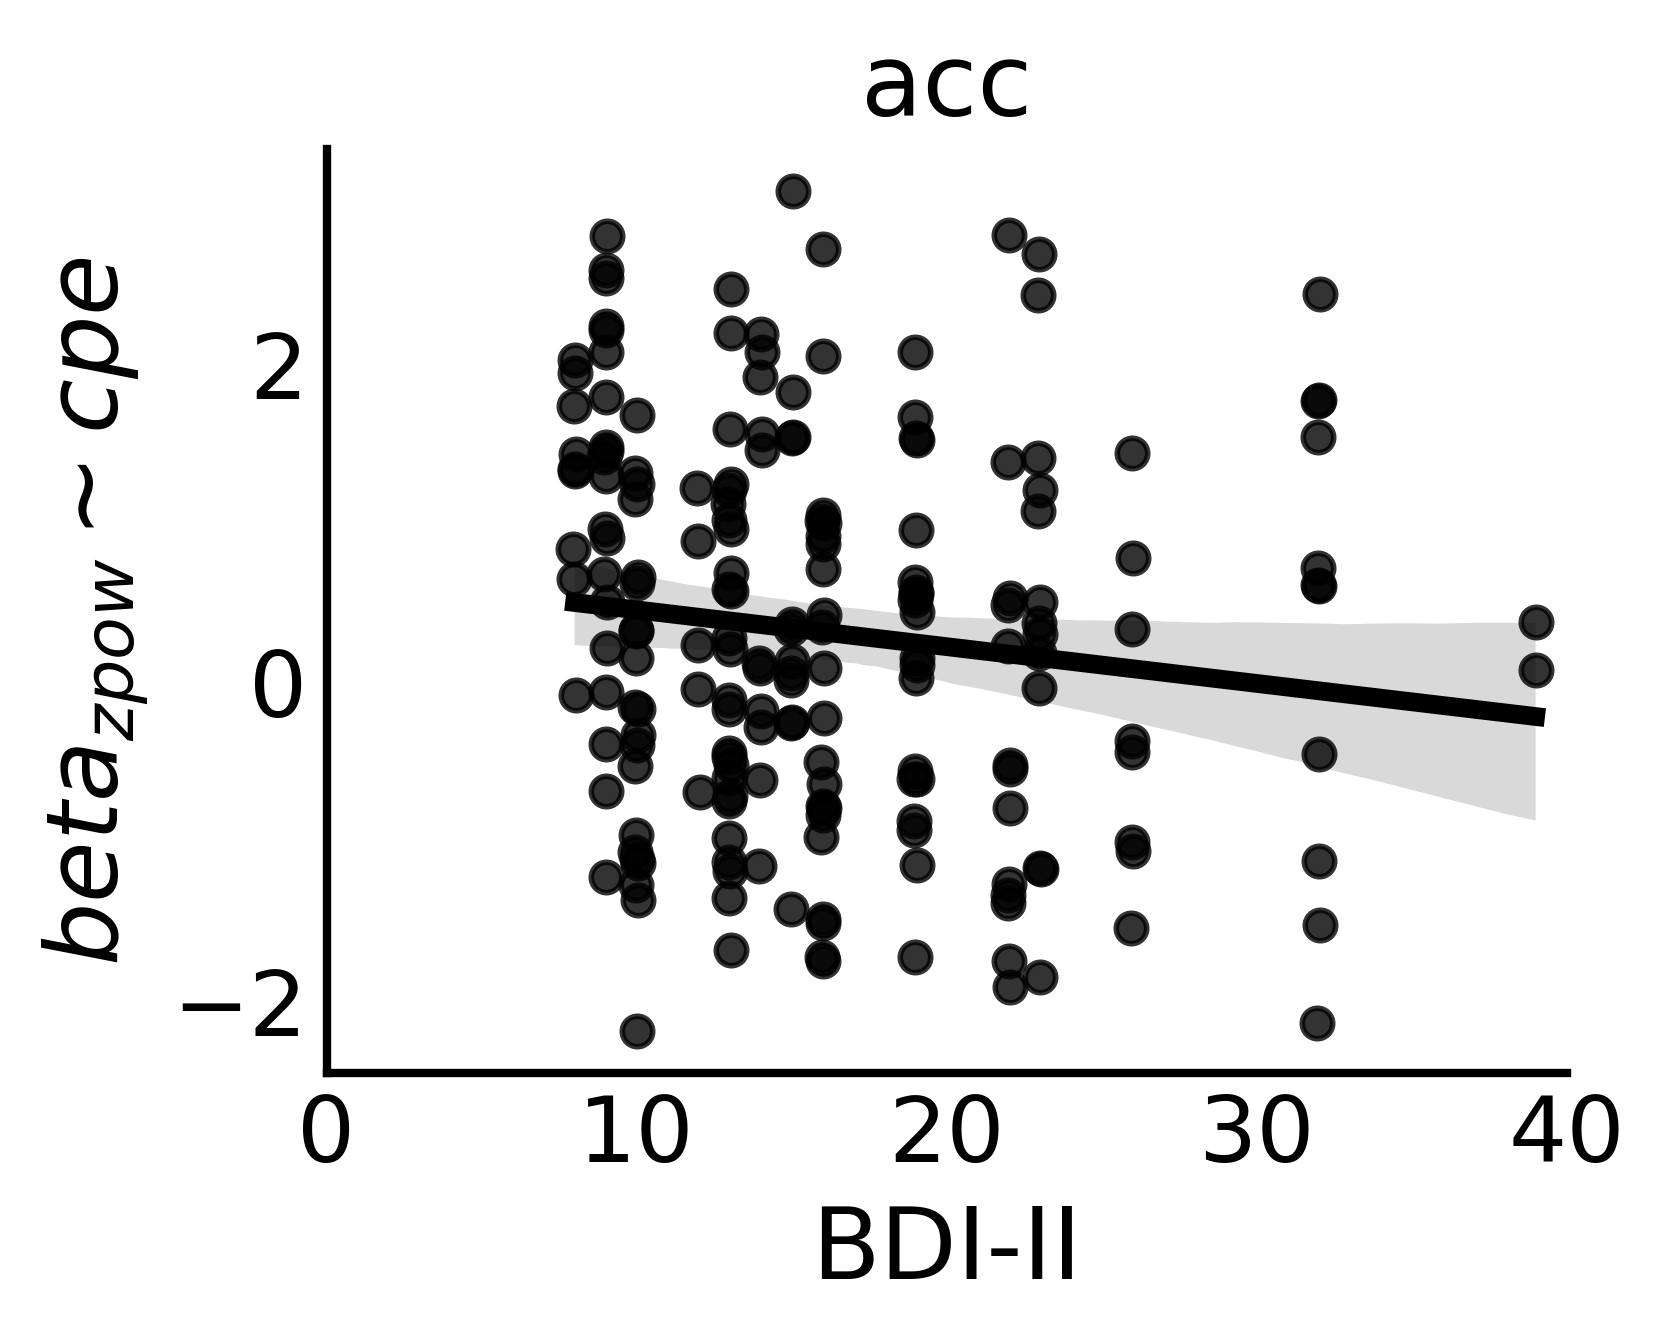

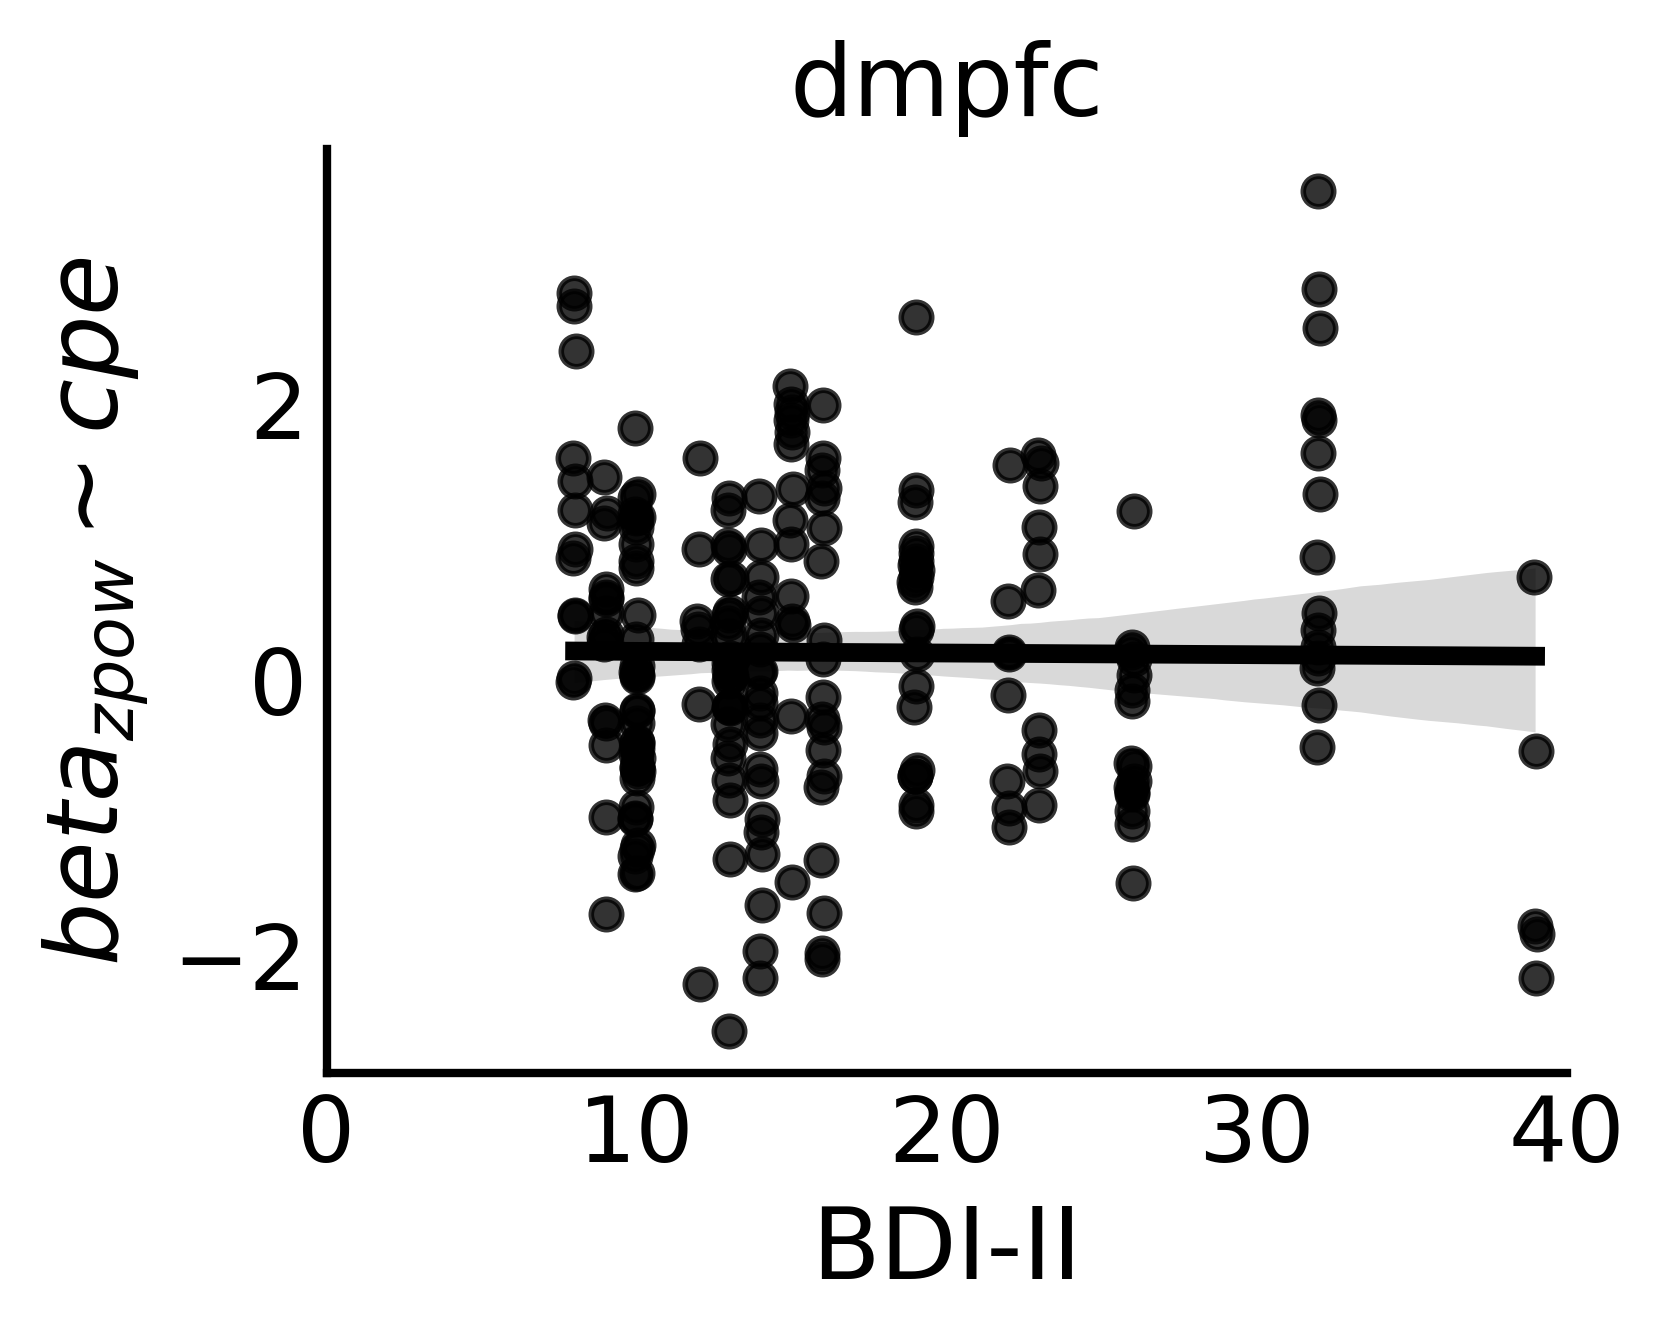

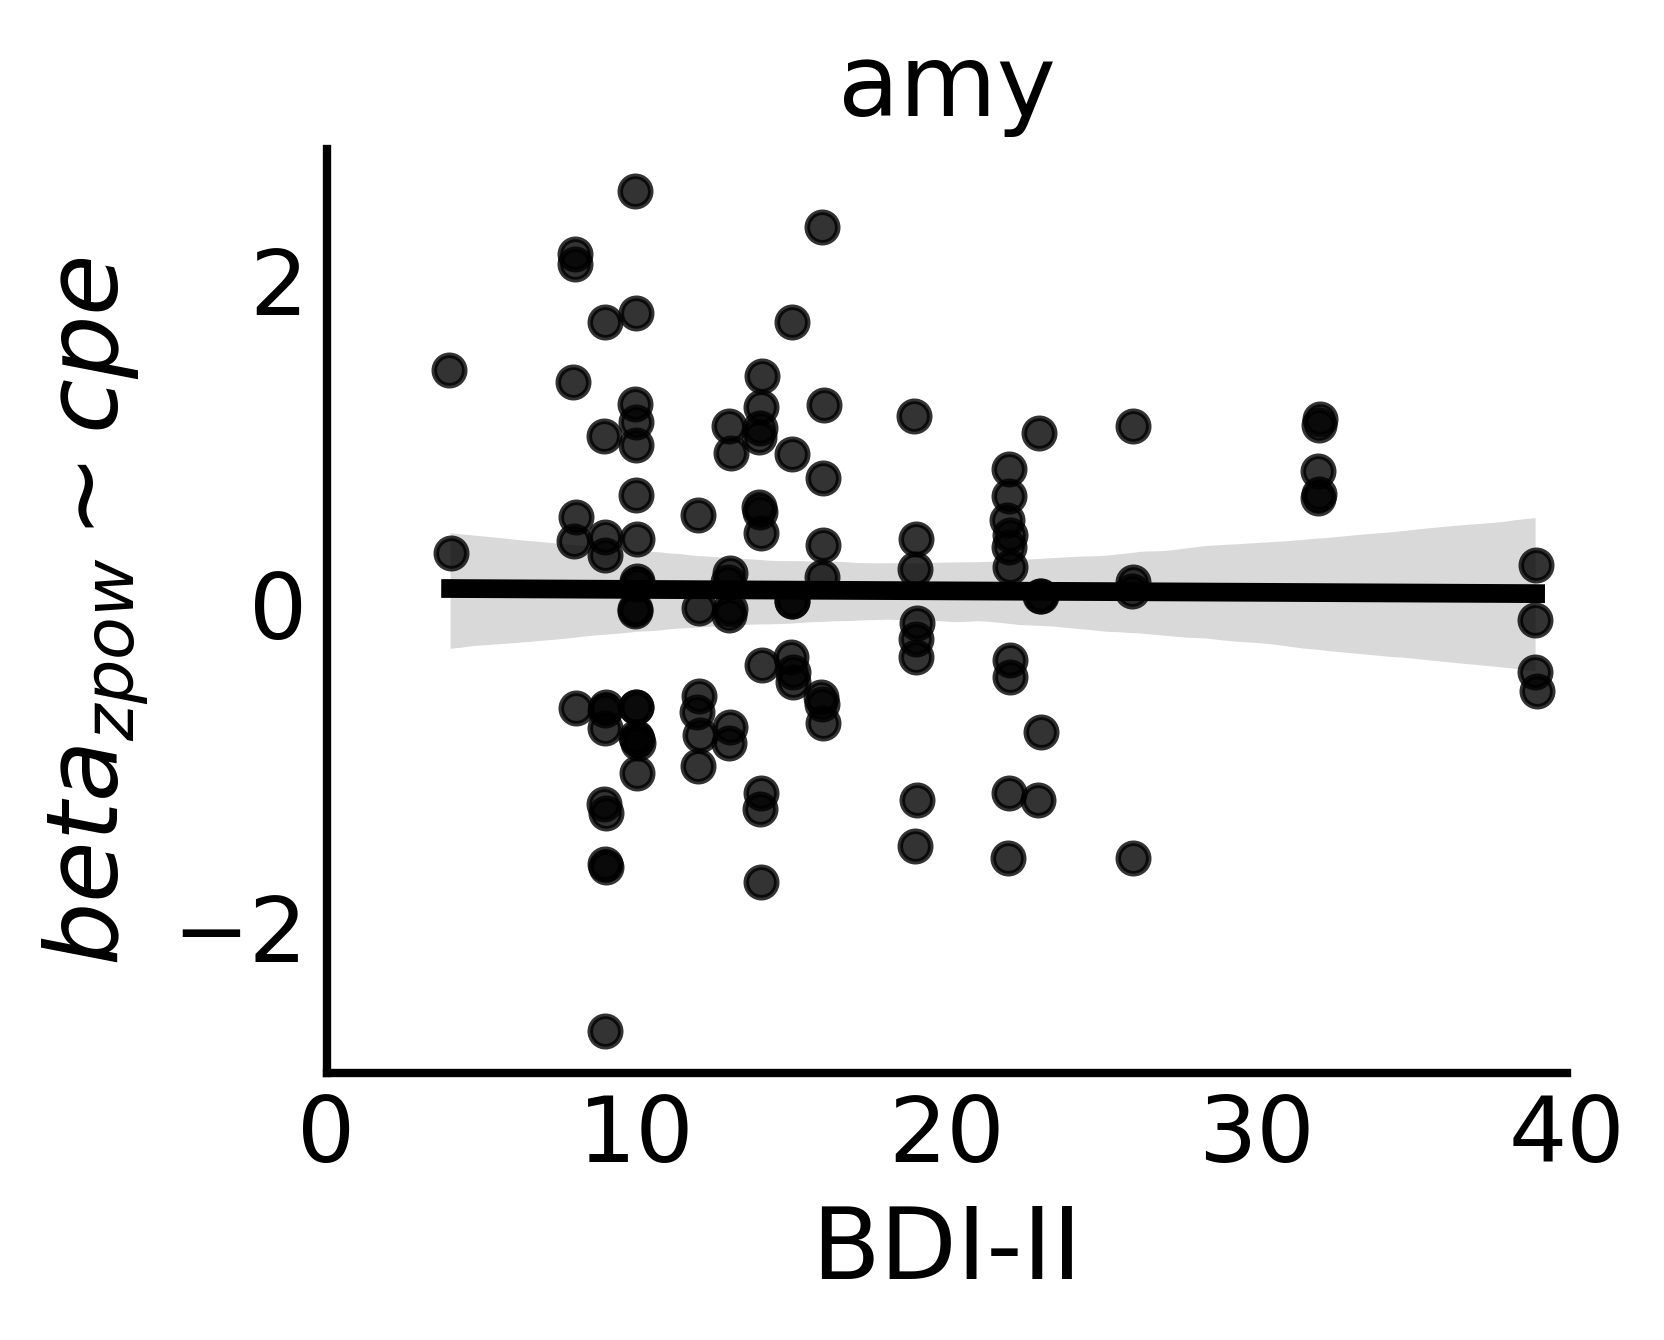

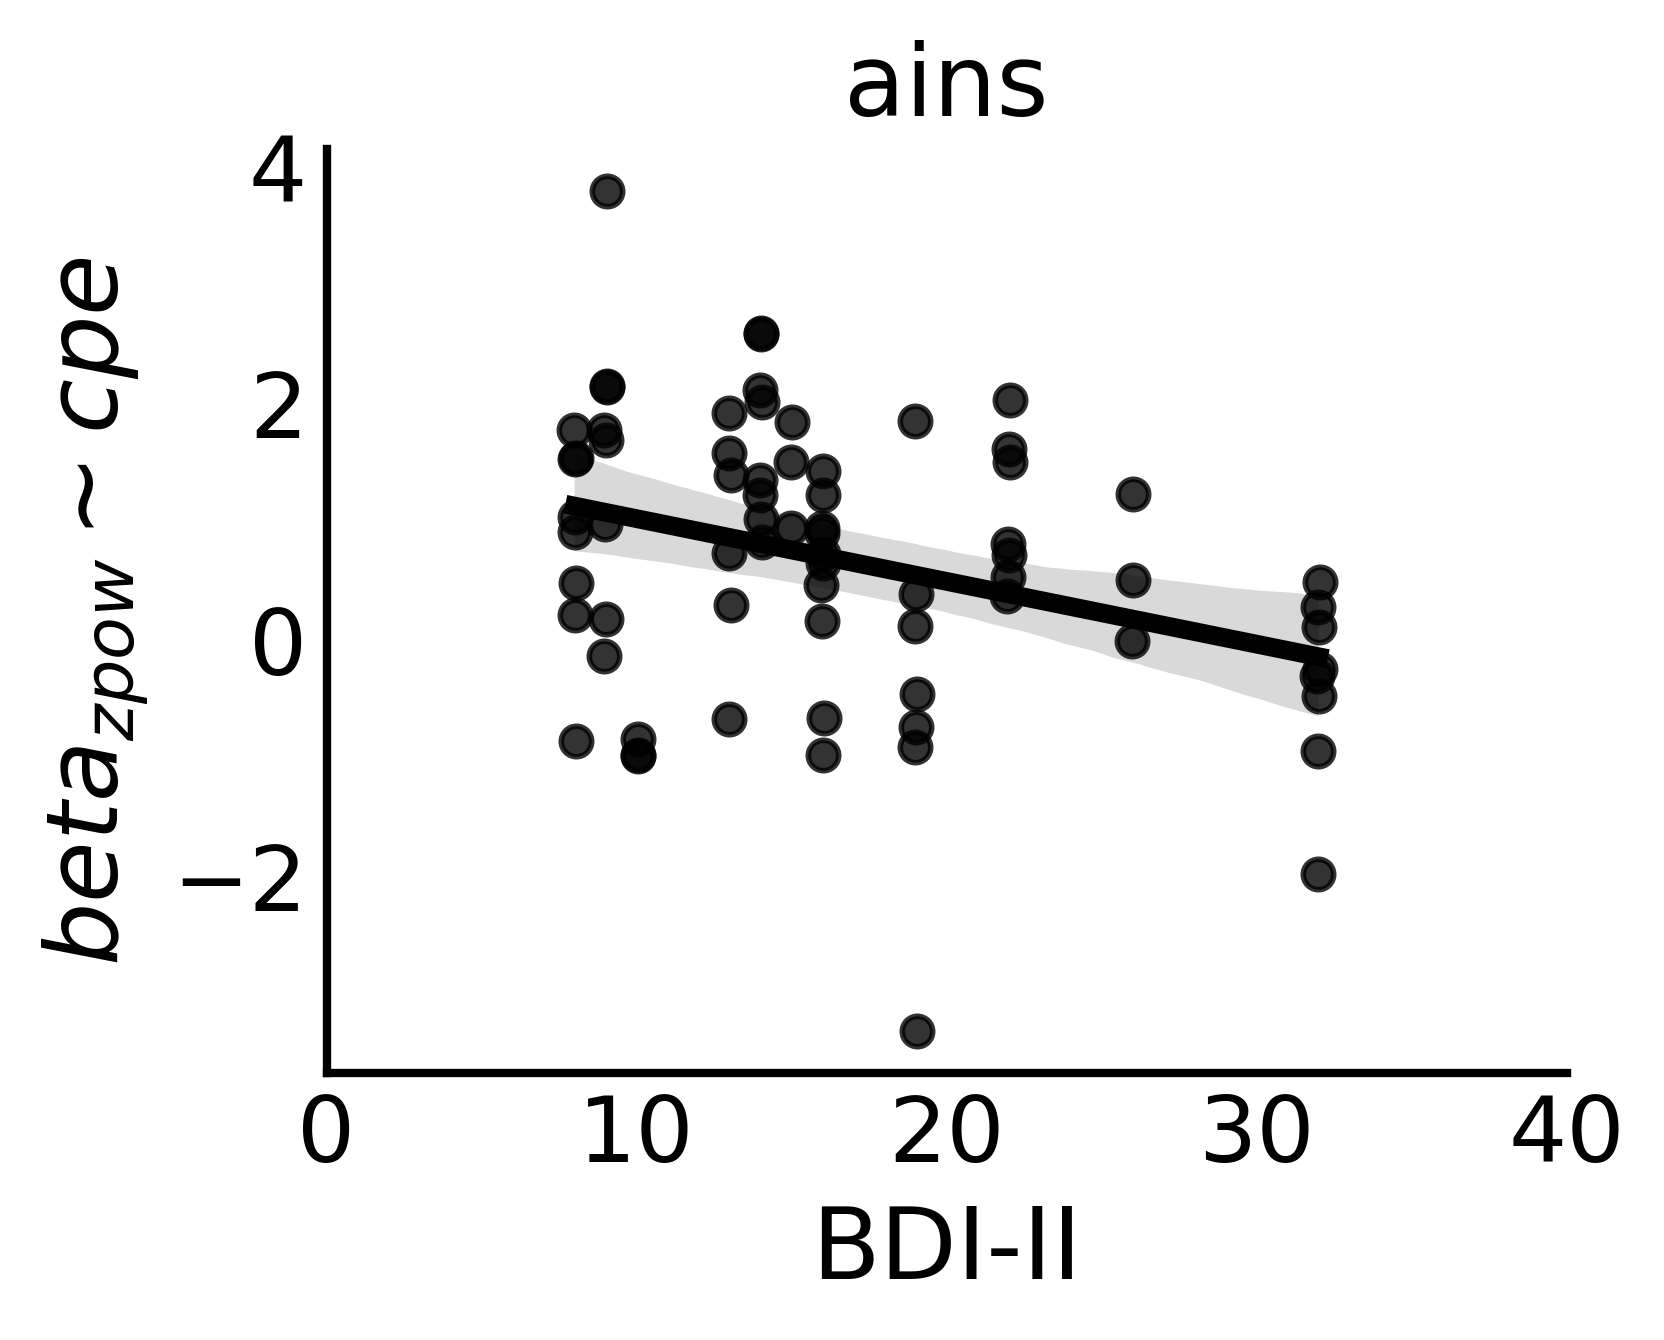

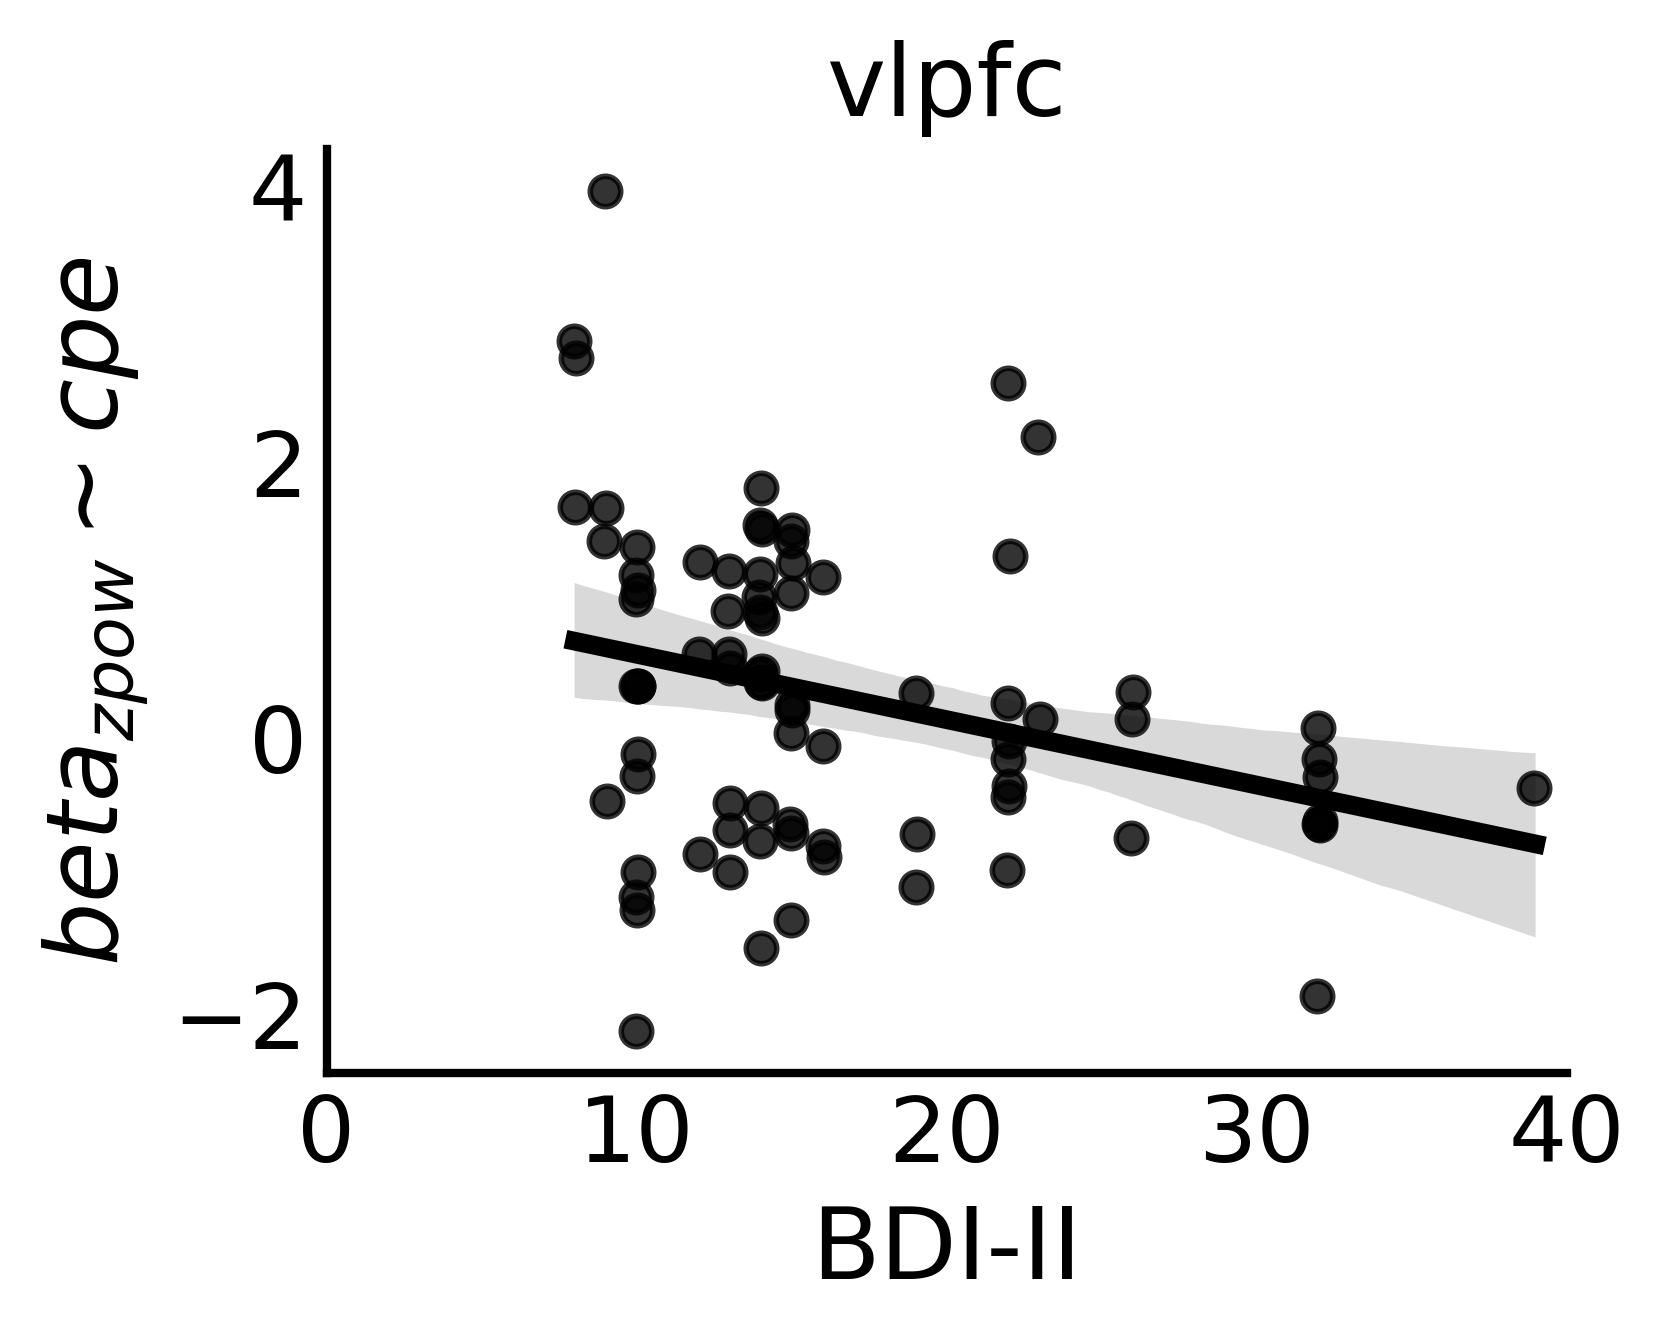

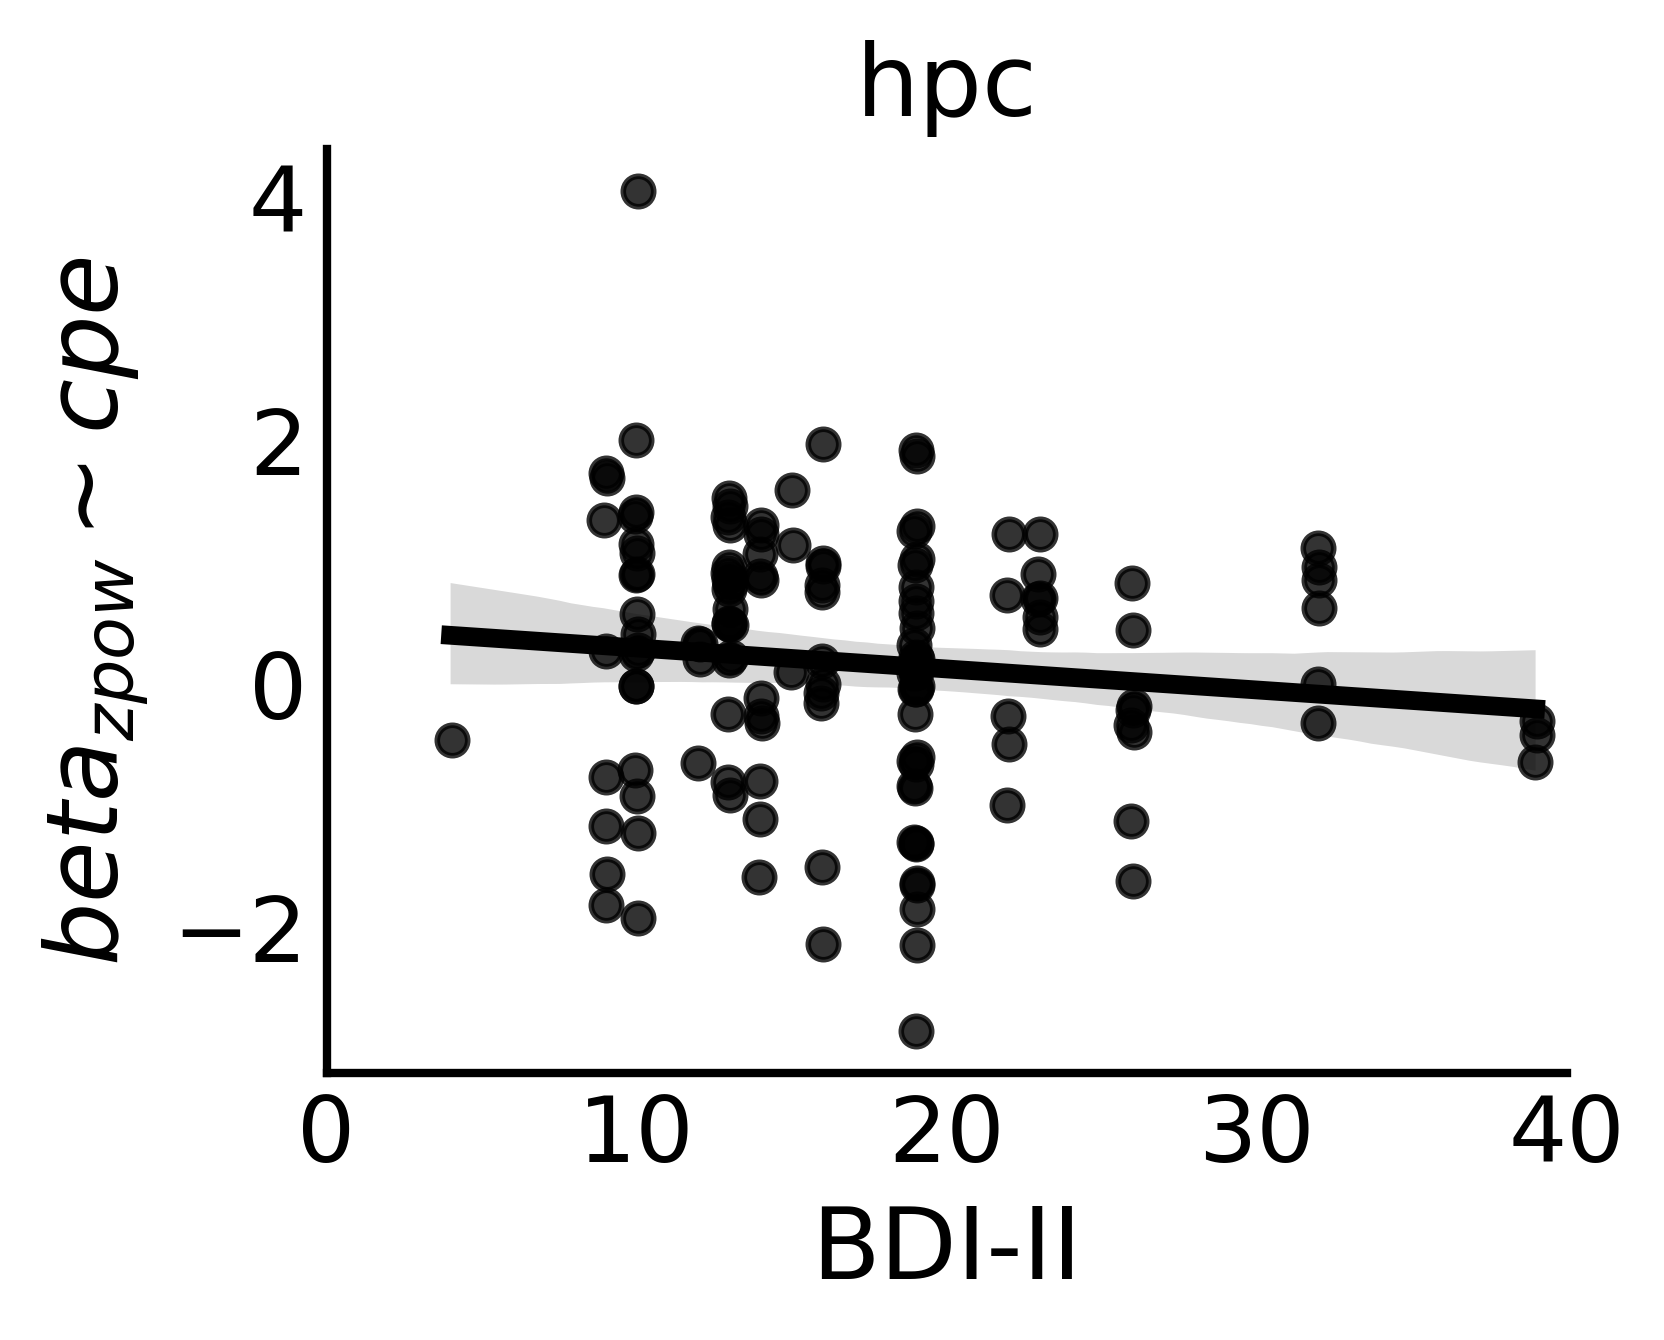

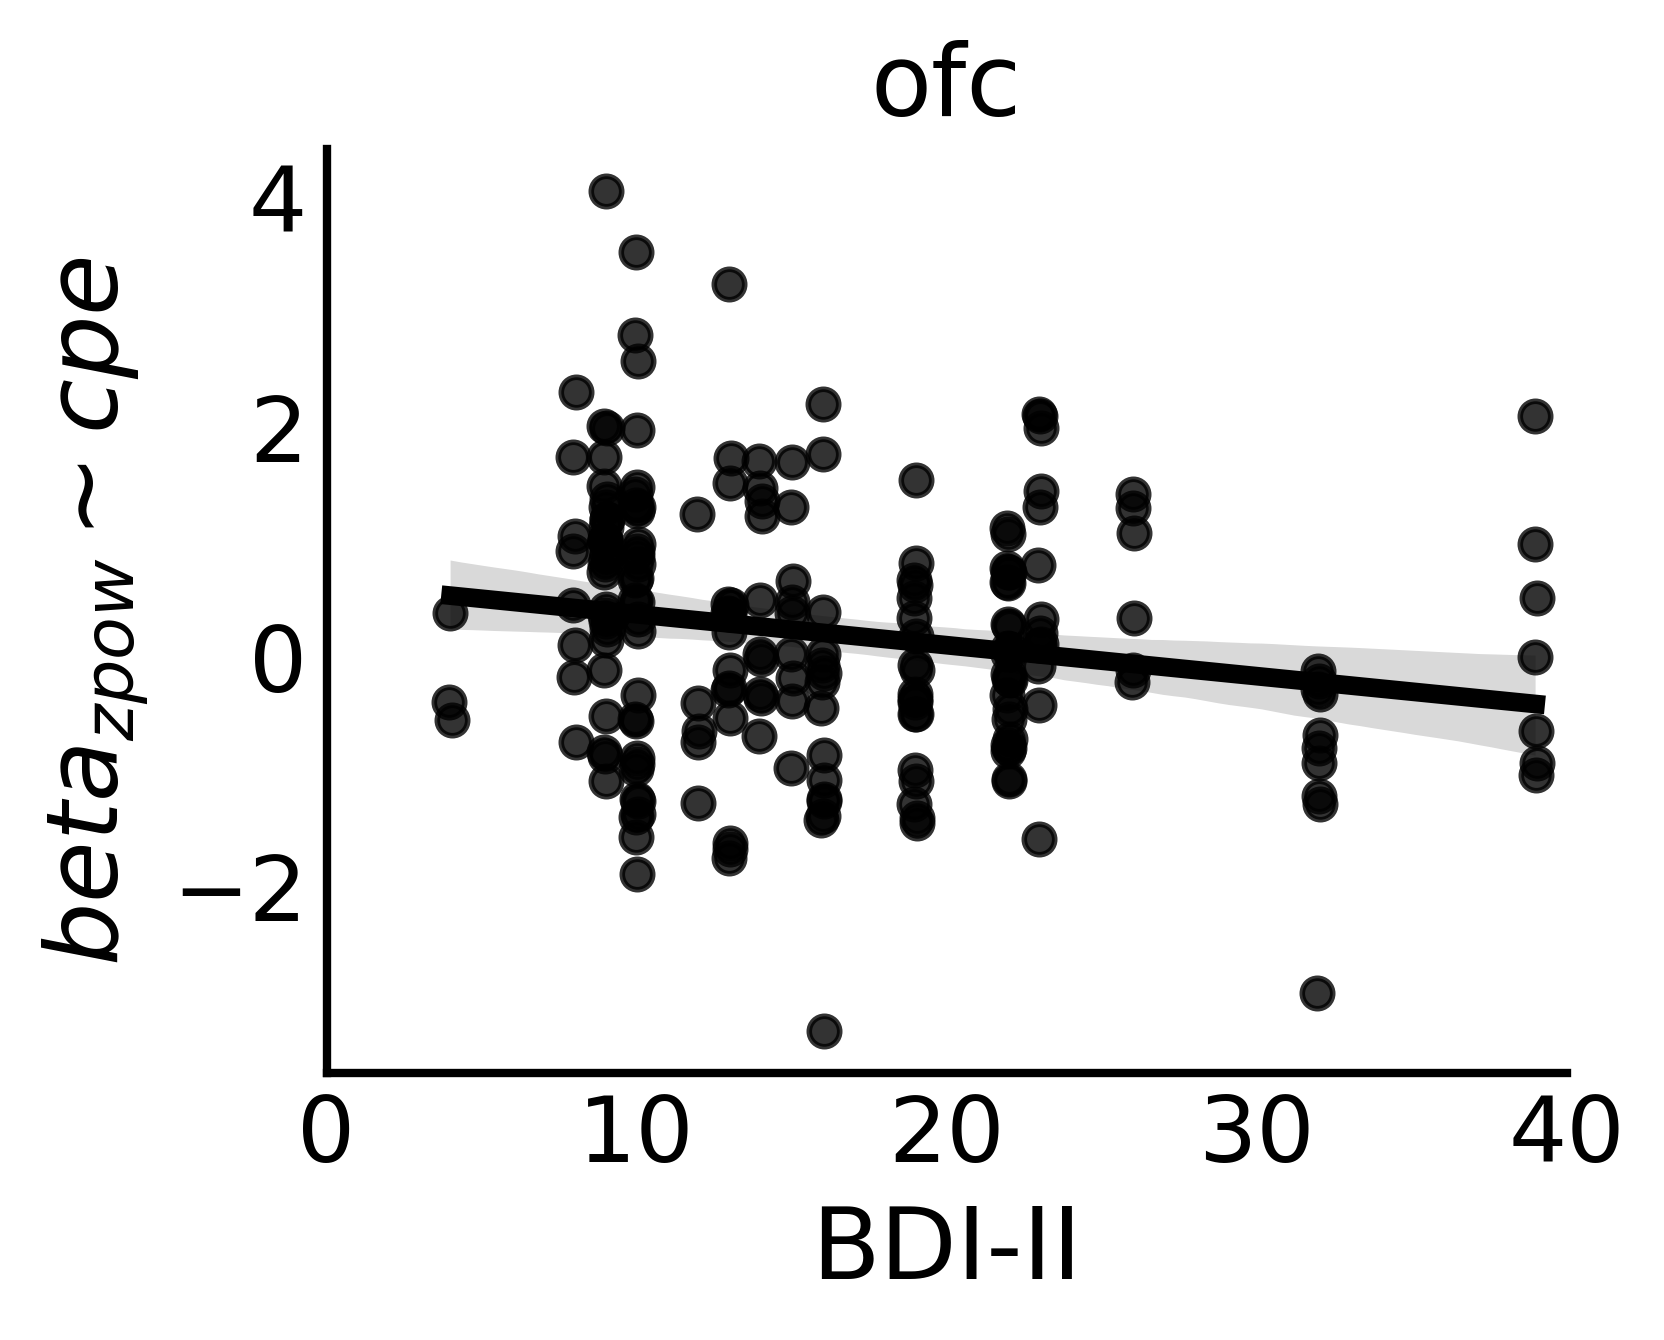

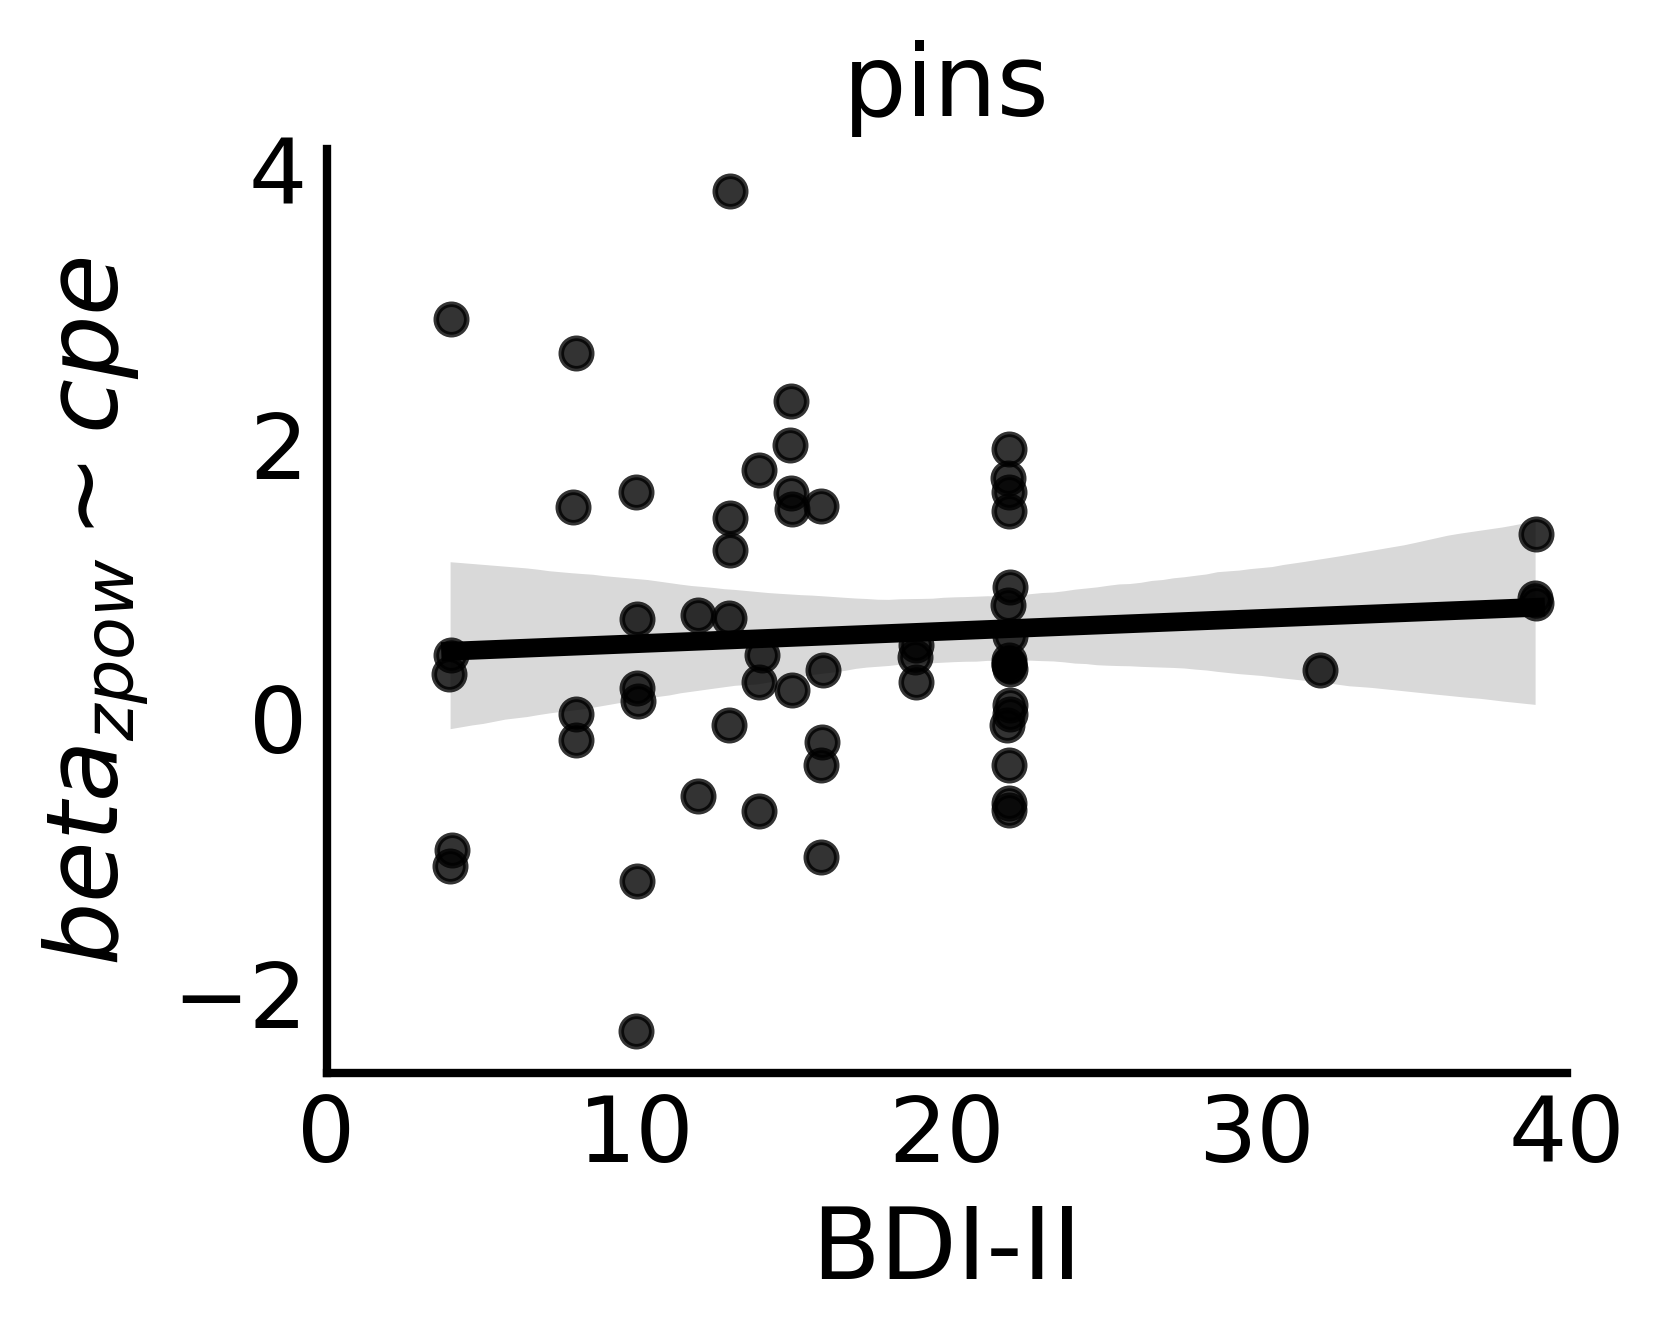

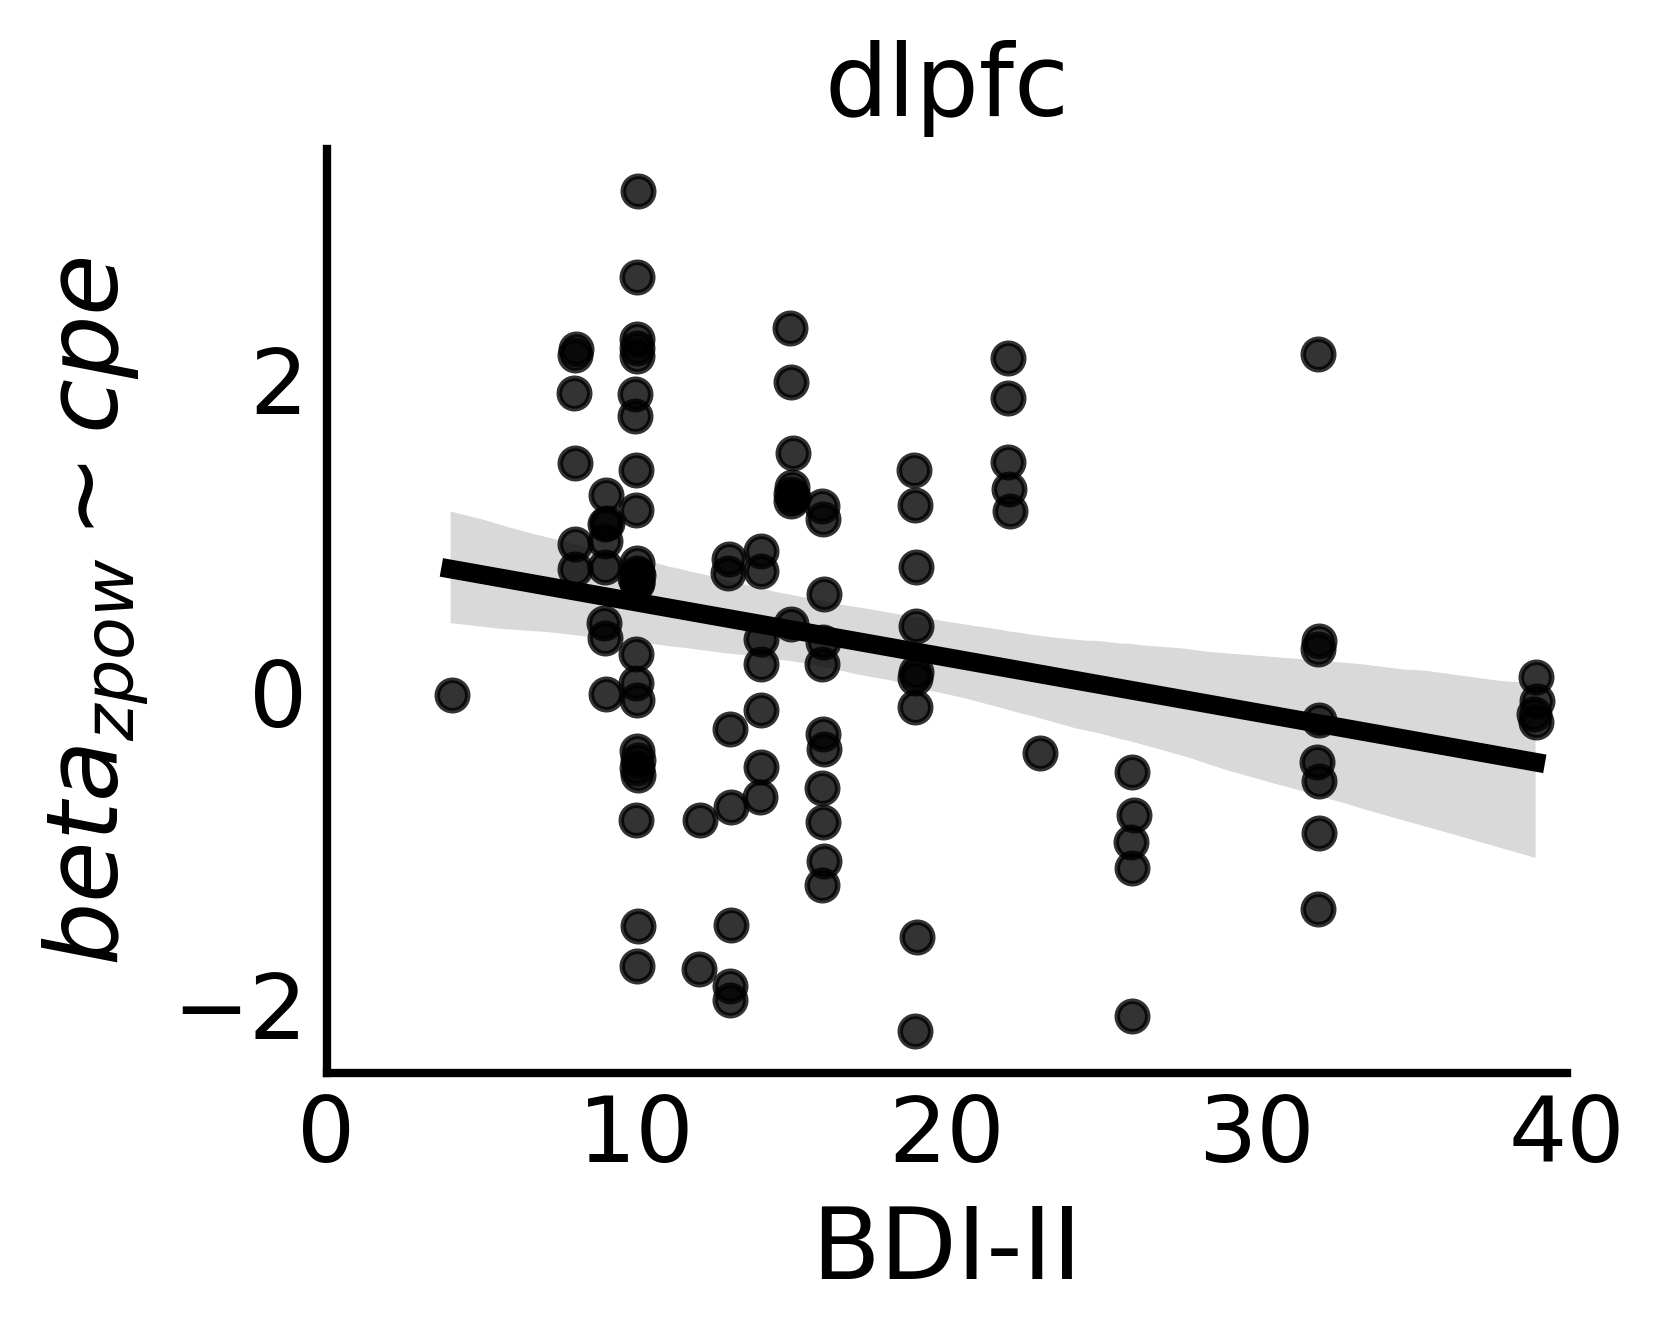

In [85]:
band = 'beta'

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in single_elec_res.roi.unique().tolist():
    
    corr_fig_id = f'{band}_{roi}_single_elec_bdi_cpe_coeff_scatter.pdf'
    
    roi_temp_data = single_elec_res[single_elec_res.roi==roi]
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=400)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_cpe',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.05,scatter_kws={'s':30}) #034975
    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
    plt.ylabel(fr'${band}_{{zpow}} \sim cpe$')


    plt.title(f'{roi}')
    sns.despine()

    plt.savefig(f'{fig_dir}{corr_fig_id}', format=corr_fig_id.split('.')[-1], metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=400,
        facecolor='auto', edgecolor='auto',
        backend=None)
    


### Test BDI Correlations via robust regression

In [87]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in single_elec_res.roi.unique().tolist():
    roi_df = single_elec_res[single_elec_res.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_cpe.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())




acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 15 Sep 2024                                         
Time:                        22:15:19                                         
No. Iterations:                    11                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.9862      0.444     36.028     

# Mixed effects models

In [19]:
beta_reg_df.columns

Index(['Unnamed: 0', 'subj_id', 'bdi', 'bdi_thresh', 'Round', 'RT',
       'TrialOnset', 'ChoiceOnset', 'DecisionOnset', 'FeedbackOnset',
       'ChoicePos', 'TrialType', 'SafeBet', 'LowBet', 'HighBet',
       'GambleChoice', 'Outcome', 'Profit', 'TotalProfit', 'epoch', 'logRT',
       'GambleEV', 'TrialEV', 'CR', 'choiceEV', 'rpe', 'res_type', 'cf',
       'max_cf', 'cpe', 'max_cpe', 'Round_t1', 'RT_t1', 'ChoicePos_t1',
       'TrialType_t1', 'SafeBet_t1', 'LowBet_t1', 'HighBet_t1',
       'GambleChoice_t1', 'Outcome_t1', 'Profit_t1', 'TotalProfit_t1',
       'epoch_t1', 'logRT_t1', 'GambleEV_t1', 'TrialEV_t1', 'CR_t1',
       'choiceEV_t1', 'rpe_t1', 'res_type_t1', 'cf_t1', 'max_cf_t1', 'cpe_t1',
       'max_cpe_t1', 'keep_epoch', 'keep_epoch_t1', 'CpeOnset',
       'reref_ch_names', 'band_pow', 'roi', 'hemi', 'unique_reref_ch'],
      dtype='object')

In [44]:
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'
reg_vars     = ['GambleChoice','TotalProfit', 'cpe']
rand_vars    = ['GambleChoice','TotalProfit', 'cpe']


In [45]:
roi_fit_dict = {f'{roi}':fit_mixed_model(beta_reg_df[beta_reg_df.roi==roi],
                                        reg_vars,rand_vars,outcome_var,rand_eff_var) 
                for roi in beta_reg_df.roi.unique().tolist()}

roi_fit_results = []

for roi in list(roi_fit_dict.keys()):
    roi_fit = mixed_eff_results_df(roi_fit_dict[roi],beta_reg_df[beta_reg_df.roi==roi])
    roi_fit_results.append(roi_fit)
    
roi_fit_results = pd.concat(roi_fit_results).reset_index(drop=True)
roi_fit_results['band'] = 'beta'
roi_fit_results.to_csv(f'{save_dir}beta_mlm_roi_fit_results_{date}.csv')

In [46]:
roi_fit_results

unique_reref_ch subj_id    roi  bdi  raw_Intercept  \
0             DA023_lac1-lac2   DA023    acc   14       0.007557   
1             DA023_lac2-lac3   DA023    acc   14       0.009373   
2             DA023_lac3-lac4   DA023    acc   14       0.005446   
3         MS002_lacas1-lacas2   MS002    acc   14       0.020417   
4         MS002_lacas2-lacas3   MS002    acc   14      -0.001510   
...                       ...     ...    ...  ...            ...   
1183  MS050_rainss10-rainss11   MS050  dlpfc    9       0.023297   
1184  MS050_rainss11-rainss12   MS050  dlpfc    9       0.016401   
1185    MS050_rainss6-rainss7   MS050  dlpfc    9       0.022590   
1186    MS050_rainss7-rainss8   MS050  dlpfc    9       0.014929   
1187   MS050_rainss9-rainss10   MS050  dlpfc    9       0.019594   

      raw_GambleChoice[T.safe]  raw_GambleChoice[T.skip]  raw_TotalProfit  \
0                    -0.020959                  0.035264        -0.014336   
1                    -0.004570                 -0.018242         0.012169   
2                    -0.002670                 -0.012703         0.003203   
3                    -0.022354                  0.069955         0.015765   
4                     0.013611                  0.077055         0.014085   
...                        ...                       ...              ...   
1183                 -0.005982                  0.034732         0.001151   
1184                 -0.001658                  0.050763        -0.003638   
1185                  0.022365                  0.042604        -0.007094   
1186                  0.025273                  0.026288        -0.008528   
1187                  0.016061                  0.100897        -0.020948   

       raw_cpe  Intercept  GambleChoice[T.safe]  GambleChoice[T.skip]  \
0     0.011173   0.005145             -0.033261             -0.018046   
1    -0.003229   0.006960             -0.016873             -0.071552   
2    -0.000999   0.003033             -0.014973             -0.066013   
3     0.012860   0.018005             -0.034657              0.016645   
4     0.009109  -0.003923              0.001308              0.023745   
...        ...        ...                   ...                   ...   
1183 -0.002198  -0.000440             -0.011725              0.122838   
1184  0.000790  -0.007336             -0.007400              0.138870   
1185 -0.004902  -0.001147              0.016622              0.130710   
1186 -0.007871  -0.008808              0.019530              0.114394   
1187 -0.009988  -0.004143              0.010319              0.189003   

      TotalProfit       cpe  band  
0       -0.013140  0.017992  beta  
1        0.013365  0.003591  beta  
2        0.004399  0.005821  beta  
3        0.016962  0.019680  beta  
4        0.015281  0.015928  beta  
...           ...       ...   ...  
1183     0.007339  0.005478  beta  
1184     0.002550  0.008467  beta  
1185    -0.000906  0.002774  beta  
1186    -0.002340 -0.000195  beta  
1187    -0.014760 -0.002312  beta  

[1188 rows x 15 columns]

In [47]:
# roi_fit_results

fe_params_results = {f'{roi}':roi_fit_dict[roi].fe_params for roi in list(roi_fit_dict.keys())}
fe_results = []
for fe_res in fe_params_results:
    fe_results.append(pd.DataFrame({**dict(fe_params_results[fe_res]),**{'roi':fe_res}},index=[0]))
    
fe_results = pd.concat(fe_results).reset_index(drop=True)
fe_results['cpe_pval'] = [np.round(roi_fit_dict[roi].pvalues['cpe'],4) for roi in fe_results.roi.tolist()]
# fe_results['bdi_pval'] = [np.round(roi_fit_dict[roi].pvalues['bdi'],4) for roi in fe_results.roi.tolist()]
# fe_results['cpe_bdi_pval'] = [np.round(roi_fit_dict[roi].pvalues['bdi:decisionCPE'],4) for roi in fe_results.roi.tolist()]

fe_results


Intercept  GambleChoice[T.safe]  GambleChoice[T.skip]  TotalProfit  \
0  -0.002413             -0.012303             -0.053309     0.001196   
1  -0.018260             -0.005384             -0.007478     0.008459   
2  -0.020557              0.001929              0.001406     0.003005   
3   0.020840             -0.013281             -0.326921     0.006674   
4  -0.013172             -0.010151             -0.206417     0.001276   
5  -0.035169              0.000882              0.026664    -0.005242   
6  -0.012966              0.000075             -0.105466     0.003220   
7  -0.012388              0.000648             -0.156904    -0.001973   
8  -0.023737             -0.005742              0.088106     0.006188   

        cpe    roi  cpe_pval  
0  0.006820    acc    0.0007  
1  0.004750  dmpfc    0.0134  
2  0.001459    amy    0.5280  
3  0.020670   ains    0.0000  
4  0.008500  vlpfc    0.0161  
5  0.002755    hpc    0.1852  
6  0.005725    ofc    0.0054  
7  0.016297   pins    0.0000  
8  0.007676  dlpfc    0.0106

In [48]:
0.05/len(fe_results)

0.005555555555555556

In [49]:

raw_roi_stats = {f'{roi}':ttest_1samp(roi_fit_results.cpe[roi_fit_results.roi == roi].unique(),
                 popmean=0) for roi in roi_fit_results.roi.unique().tolist()}
raw_roi_stats



{'acc': TtestResult(statistic=9.442165695793191, pvalue=1.2665567233981649e-17, df=192),
 'dmpfc': TtestResult(statistic=9.610014035260797, pvalue=1.5767593165857524e-18, df=224),
 'amy': TtestResult(statistic=3.8508386943719968, pvalue=0.00019644852560104852, df=112),
 'ains': TtestResult(statistic=12.455001064552201, pvalue=1.9929245875102963e-19, df=70),
 'vlpfc': TtestResult(statistic=5.403814129233931, pvalue=6.402625418597232e-07, df=81),
 'hpc': TtestResult(statistic=6.005199692855932, pvalue=1.6922236640690355e-08, df=134),
 'ofc': TtestResult(statistic=9.252615447695687, pvalue=3.315775735836558e-17, df=201),
 'pins': TtestResult(statistic=8.525035887524975, pvalue=7.125116541021535e-12, df=59),
 'dlpfc': TtestResult(statistic=5.917757962626771, pvalue=4.061352755780403e-08, df=106)}

In [50]:
fe_results.set_index('roi')

Intercept  GambleChoice[T.safe]  GambleChoice[T.skip]  TotalProfit  \
roi                                                                         
acc    -0.002413             -0.012303             -0.053309     0.001196   
dmpfc  -0.018260             -0.005384             -0.007478     0.008459   
amy    -0.020557              0.001929              0.001406     0.003005   
ains    0.020840             -0.013281             -0.326921     0.006674   
vlpfc  -0.013172             -0.010151             -0.206417     0.001276   
hpc    -0.035169              0.000882              0.026664    -0.005242   
ofc    -0.012966              0.000075             -0.105466     0.003220   
pins   -0.012388              0.000648             -0.156904    -0.001973   
dlpfc  -0.023737             -0.005742              0.088106     0.006188   

            cpe  cpe_pval  
roi                        
acc    0.006820    0.0007  
dmpfc  0.004750    0.0134  
amy    0.001459    0.5280  
ains   0.020670    0.0000  
vlpfc  0.008500    0.0161  
hpc    0.002755    0.1852  
ofc    0.005725    0.0054  
pins   0.016297    0.0000  
dlpfc  0.007676    0.0106

In [51]:
bonferr_alpha = 0.05/len(fe_results)
# bonferr_alpha = 0.01

bonferr_alpha



0.005555555555555556

In [59]:
sig_cpe_rois = fe_results.roi[fe_results.cpe_pval <= bonferr_alpha].tolist()
sig_cpe_rois



['acc', 'ains', 'ofc', 'pins']

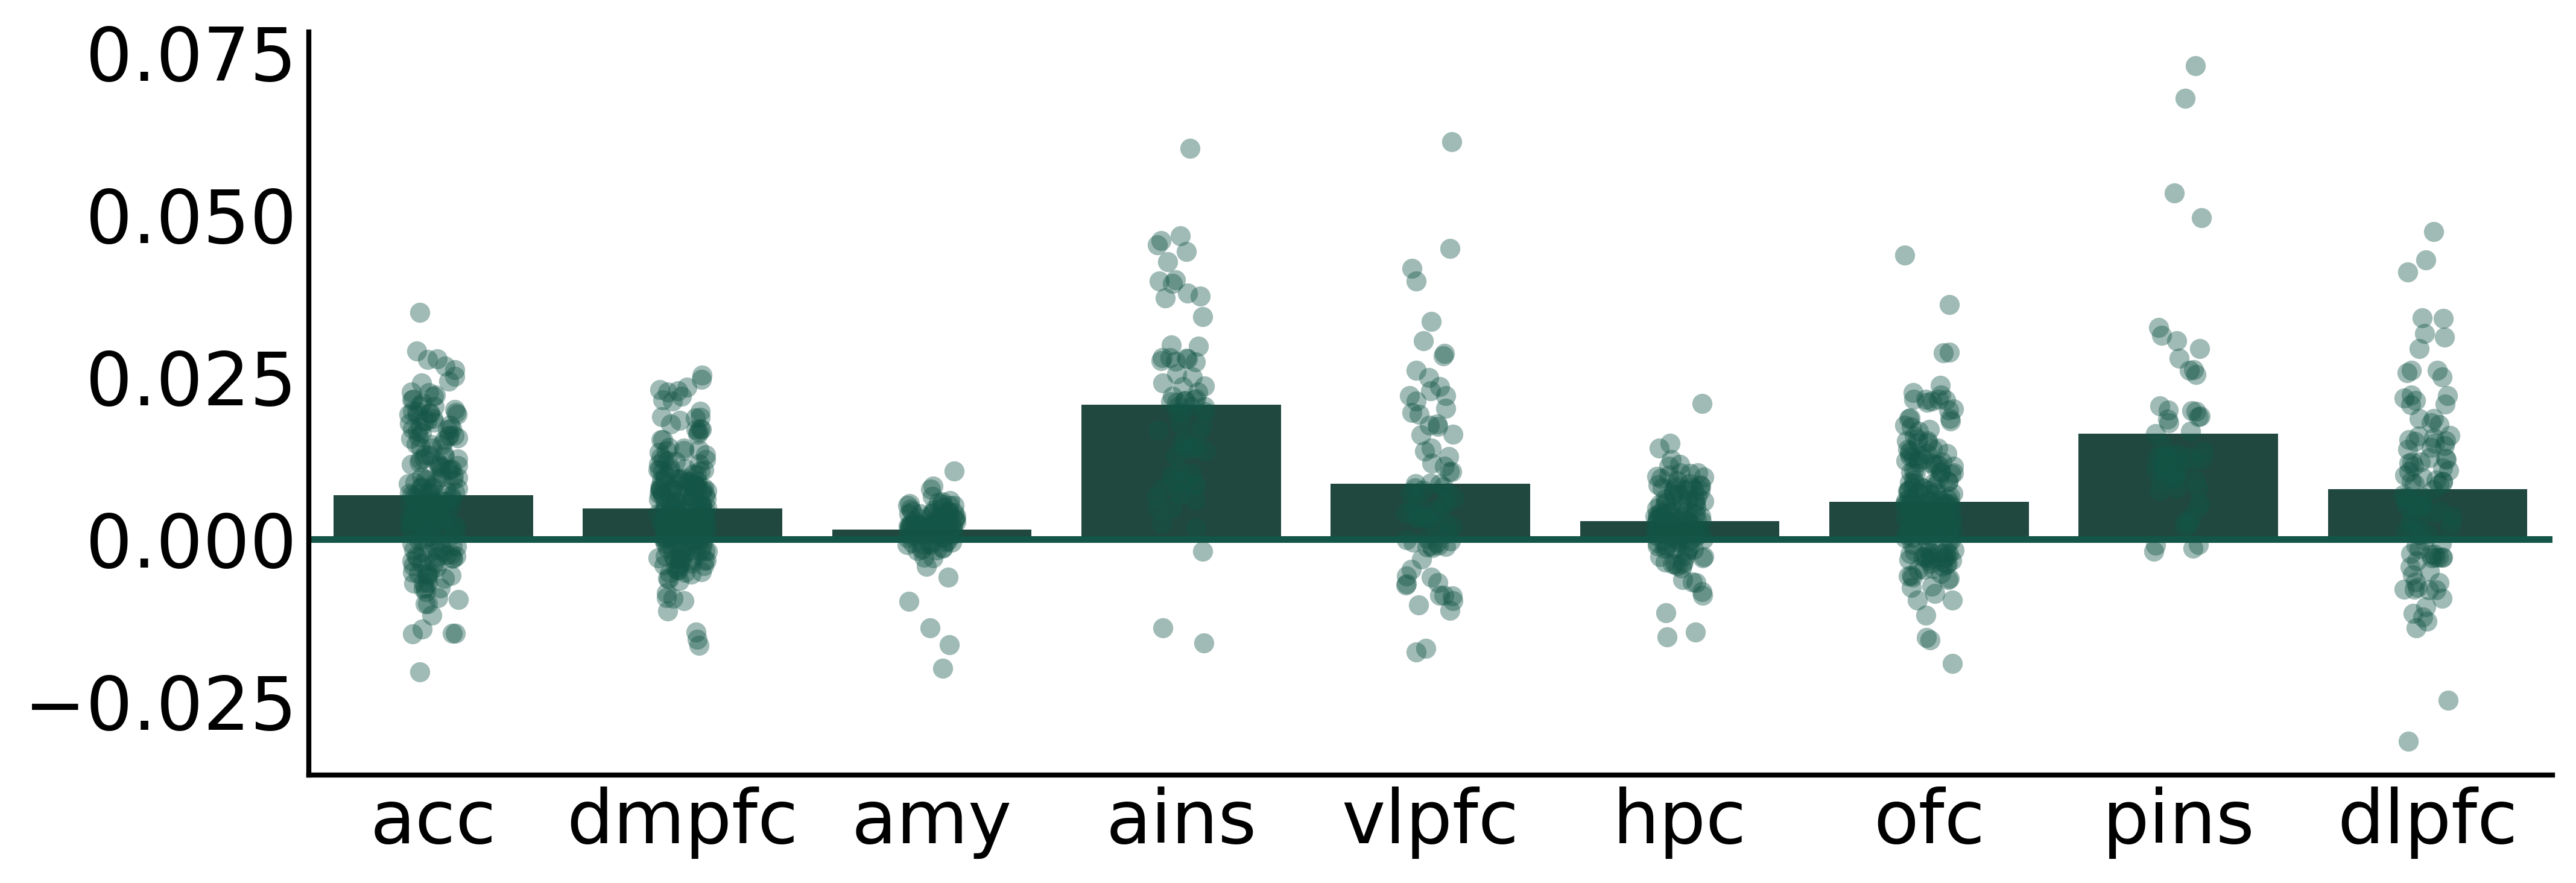

In [60]:
plot_roi_model_results(roi_fit_results,'roi','cpe',figsize=(12,4),color='#135546')



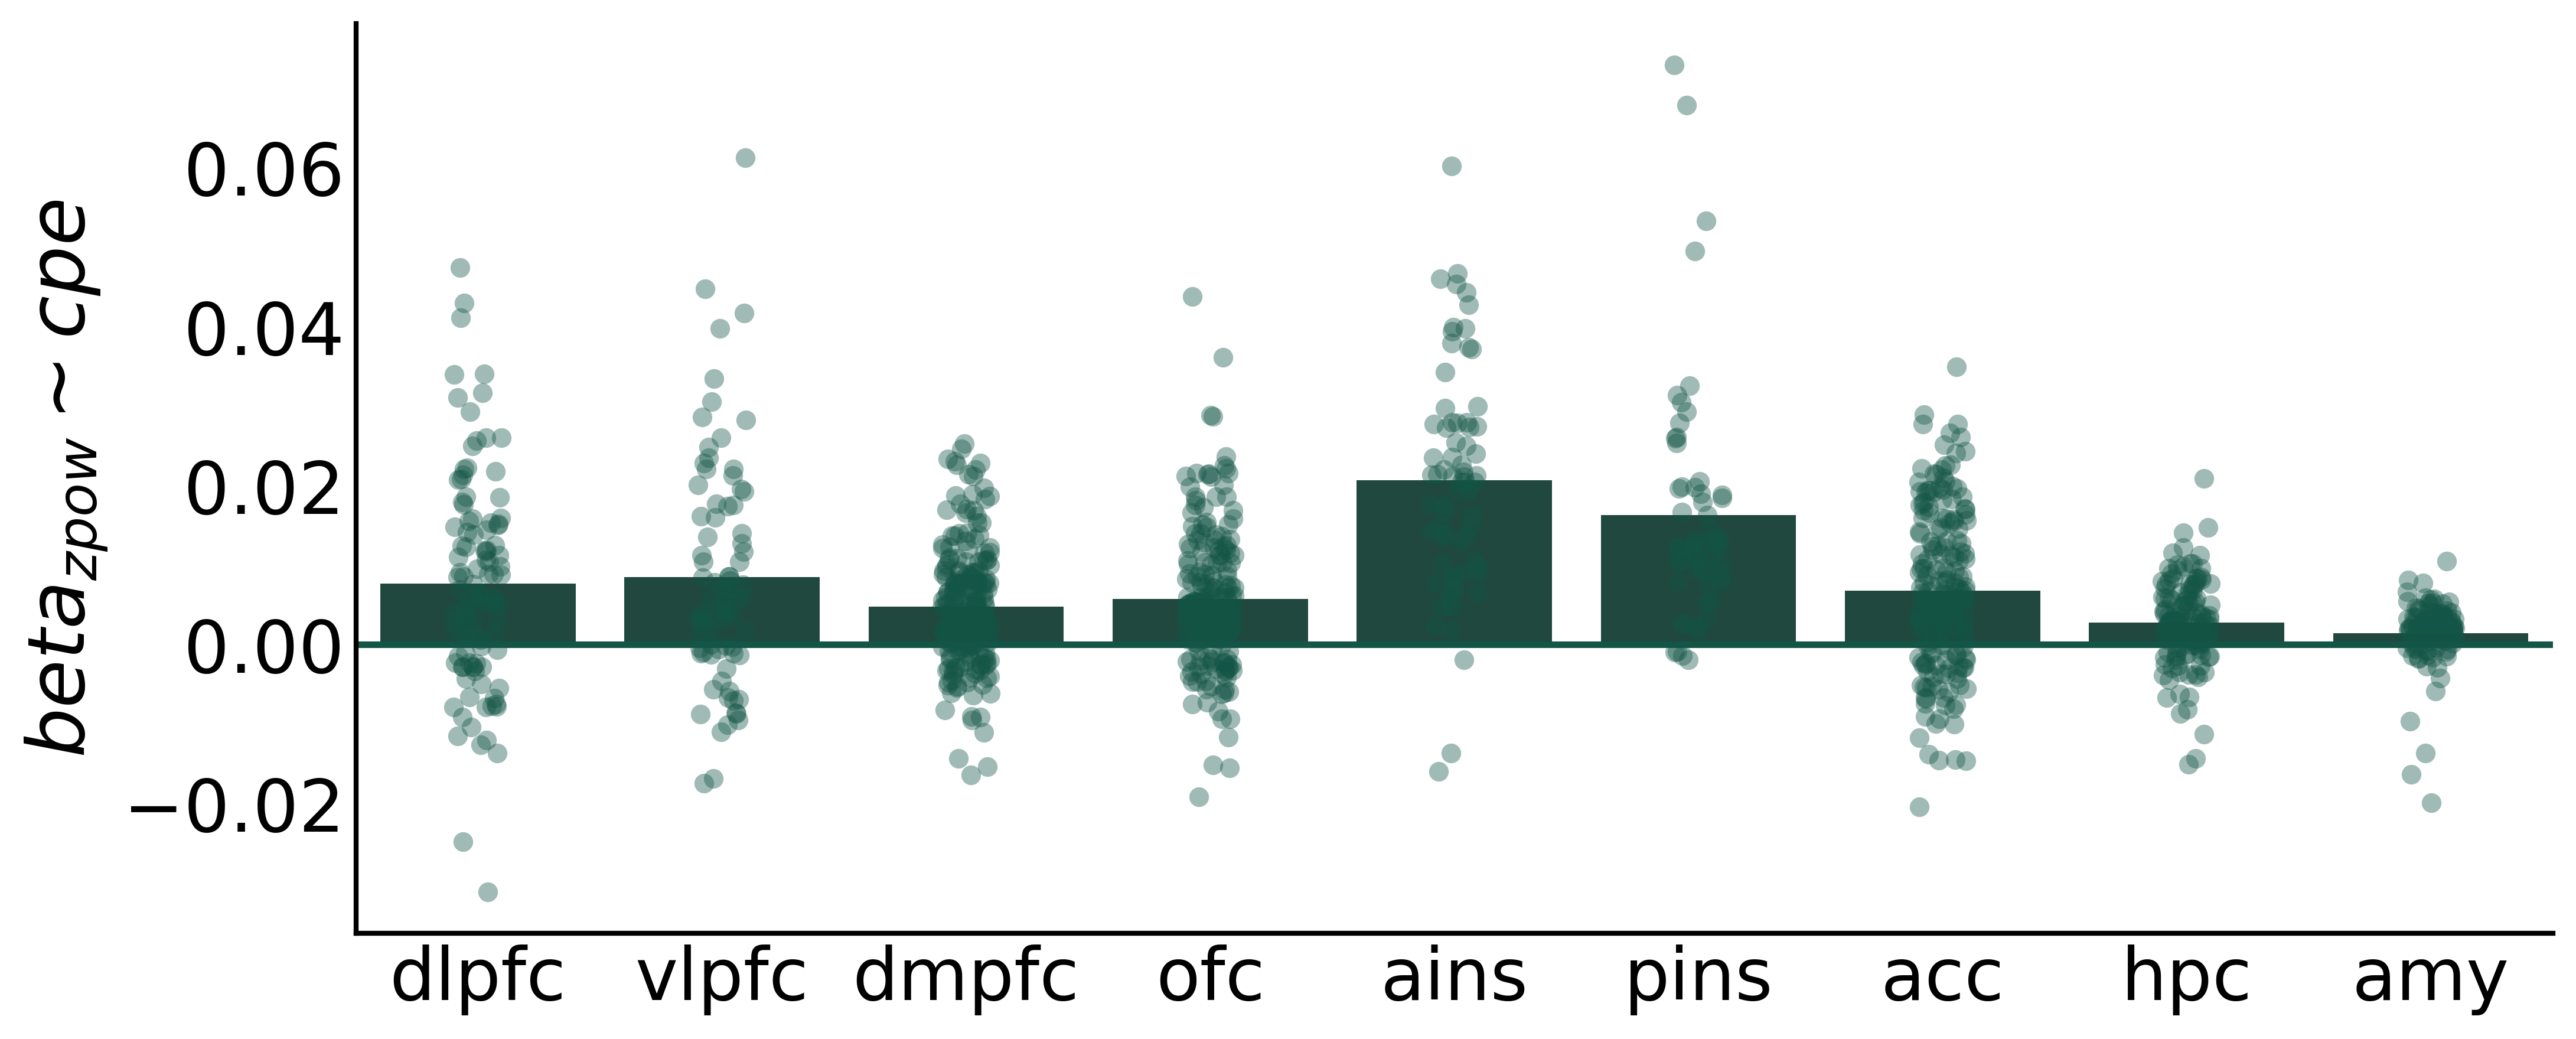

In [91]:
ylabel = fr'${band}_{{zpow}} \sim cpe$'
# fig_save_dir = '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/results/single-electrode-regressions/'
fig_id = f'{band}_mlm_roi_barplot.pdf'


plot_roi_model_results(roi_fit_results,'roi','cpe',bar_order=bar_order,figsize=(12,5),color='#135546',
                       ylabel=ylabel,save_fig=True,save_dir=fig_dir,fig_id=fig_id,dpi=400)



# BDI Correlation

In [55]:
# CHECK BDI CORRELATION

rho_data = []
sig_rho = []

# BDI CORRELATIONS
for roi in roi_fit_results.roi.unique().tolist():
    roi_temp_data = roi_fit_results[roi_fit_results.roi==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.cpe)
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
    rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':rho_p},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
#     if rho_p < bonferr_alpha:
    if rho_p < 0.05:
        sig_rho.append((roi,rho,rho_p))
    print(f'{roi} pearsonr',rho,rho_p)
rho_data = pd.concat(rho_data).reset_index(drop=True)


acc pearsonr -0.20425085160766068 0.004382797564355383
dmpfc pearsonr -0.053219014087662594 0.4269613979335593
amy pearsonr -0.4401634242790923 1.0695097173718118e-06
ains pearsonr -0.4882081539764731 1.567428887741411e-05
vlpfc pearsonr -0.25551539597404305 0.020510737570808544
hpc pearsonr -0.33883421995755864 5.823202478705162e-05
ofc pearsonr -0.22341028262870527 0.0013932514106345998
pins pearsonr 0.021378588077406946 0.8712012856895682
dlpfc pearsonr -0.18146620993762935 0.06139830741406018


In [56]:
sig_rho

[('acc', -0.20425085160766068, 0.004382797564355383),
 ('amy', -0.4401634242790923, 1.0695097173718118e-06),
 ('ains', -0.4882081539764731, 1.567428887741411e-05),
 ('vlpfc', -0.25551539597404305, 0.020510737570808544),
 ('hpc', -0.33883421995755864, 5.823202478705162e-05),
 ('ofc', -0.22341028262870527, 0.0013932514106345998)]

In [ ]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in single_elec_res.roi.unique().tolist():
    roi_df = single_elec_res[single_elec_res.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_decisionCPE.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())


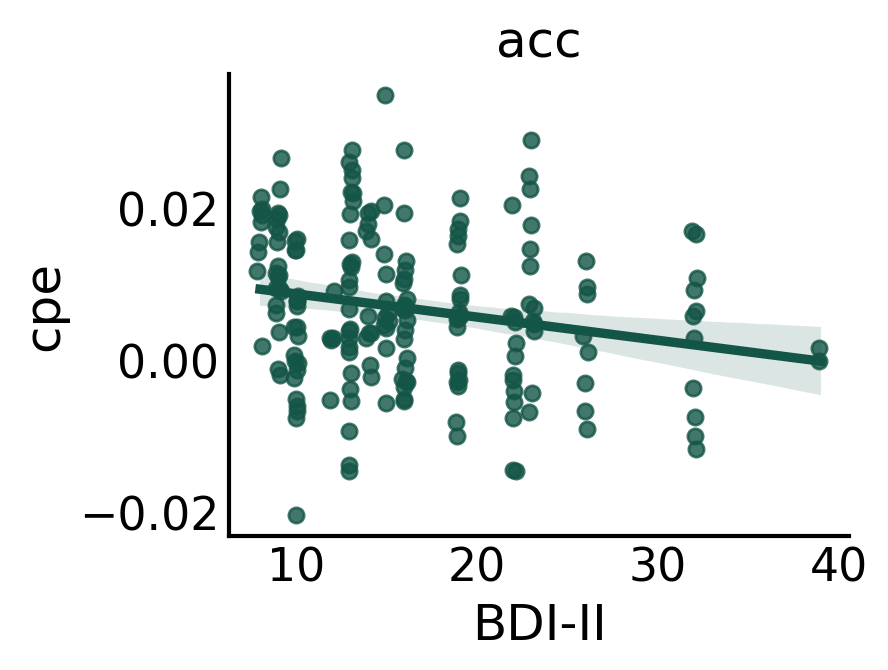

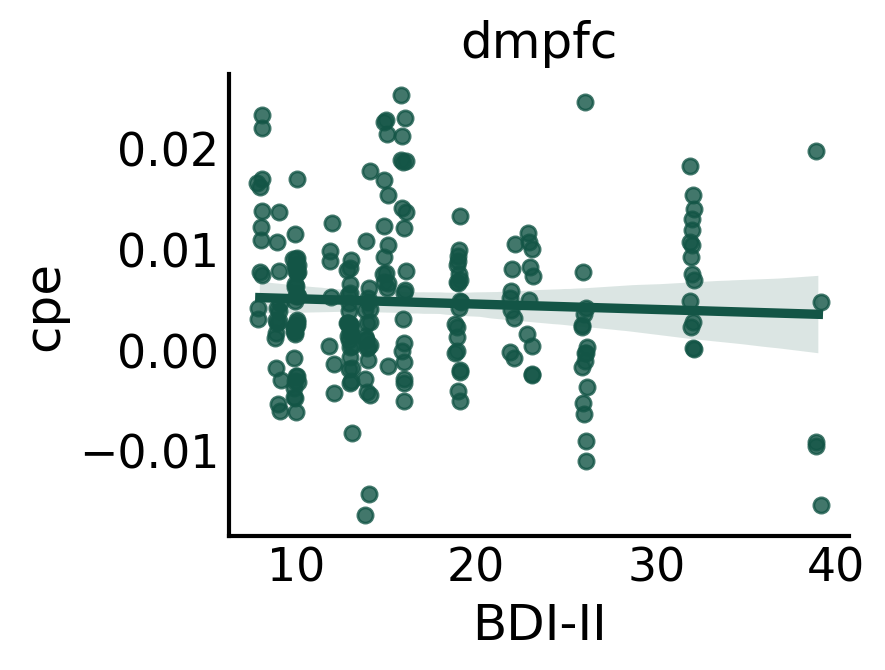

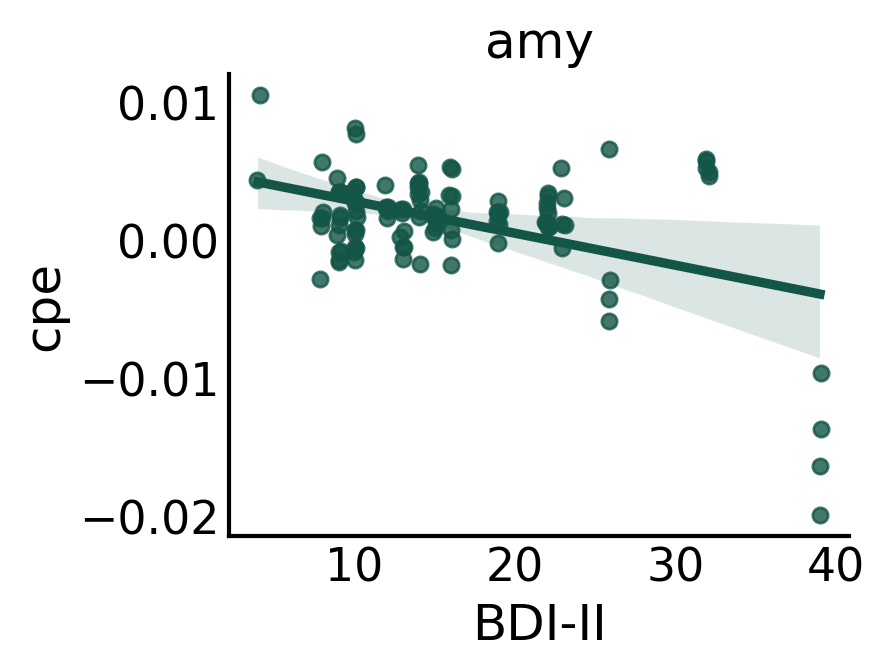

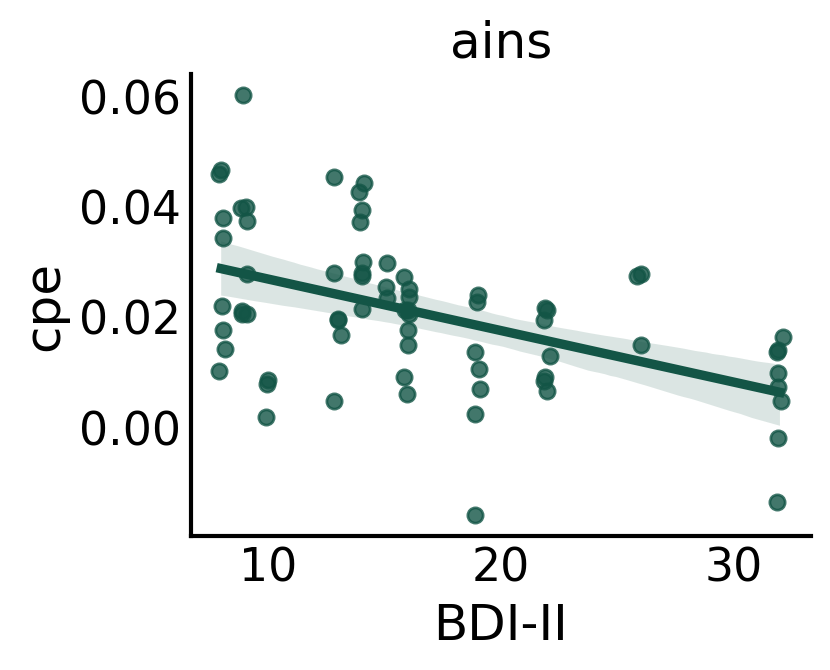

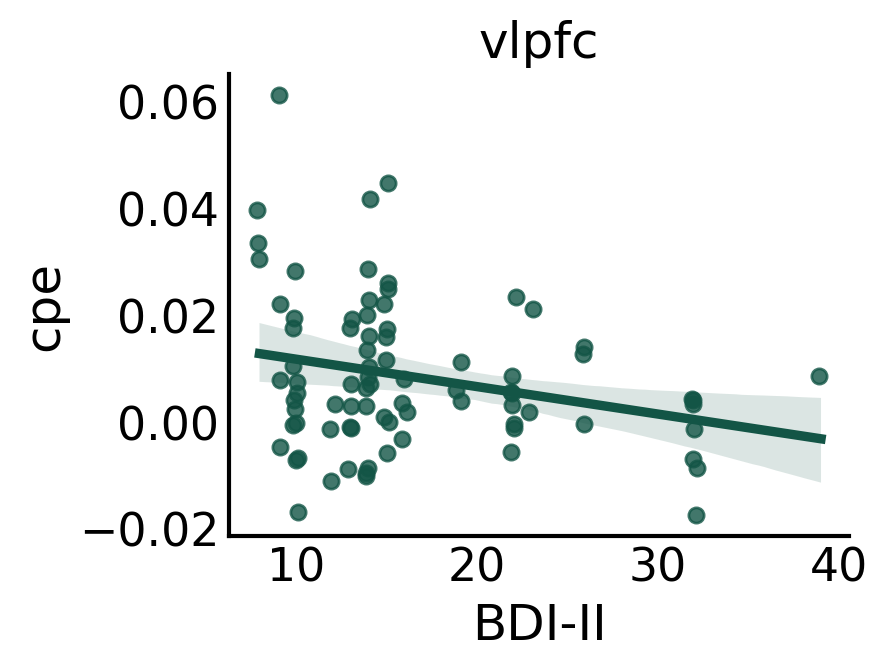

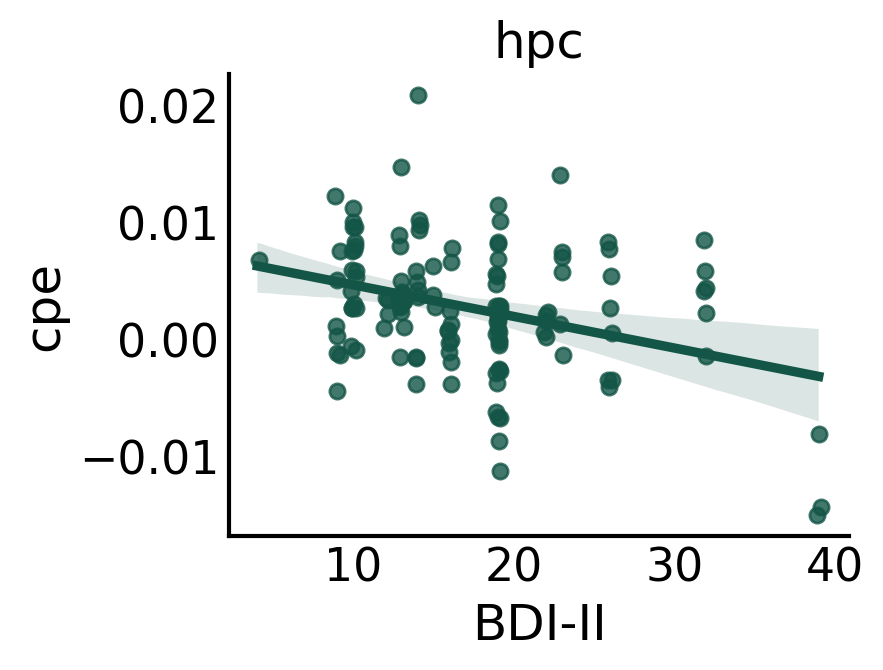

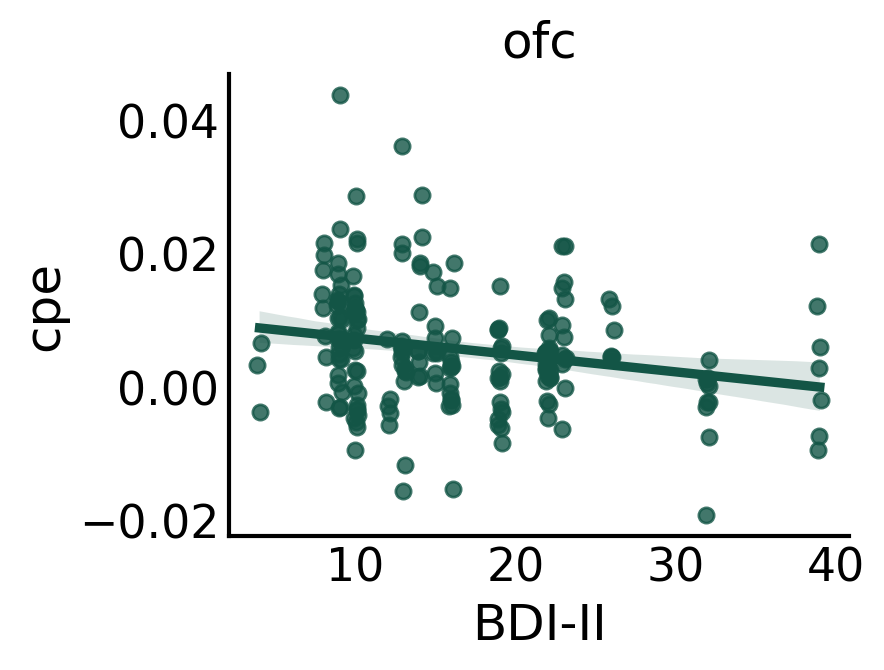

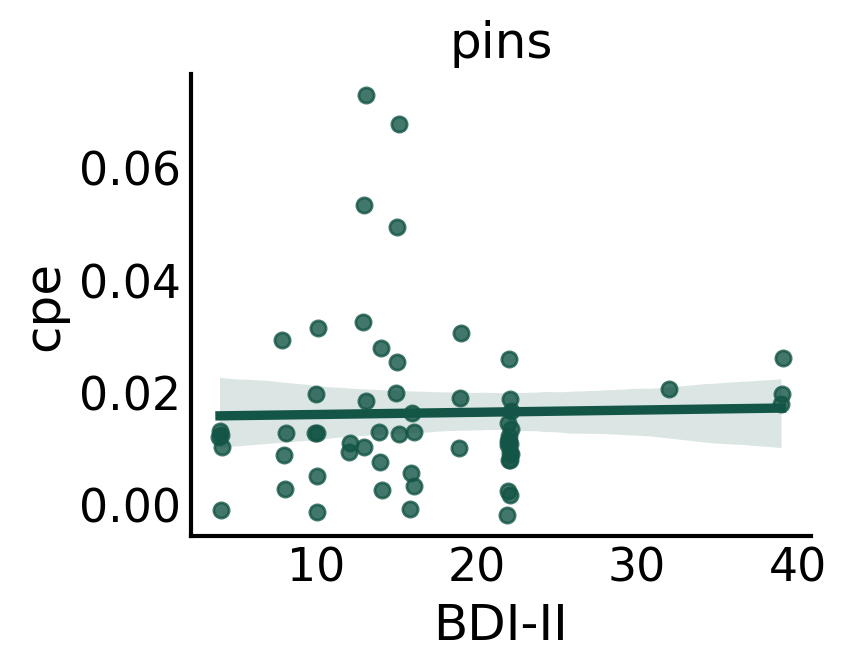

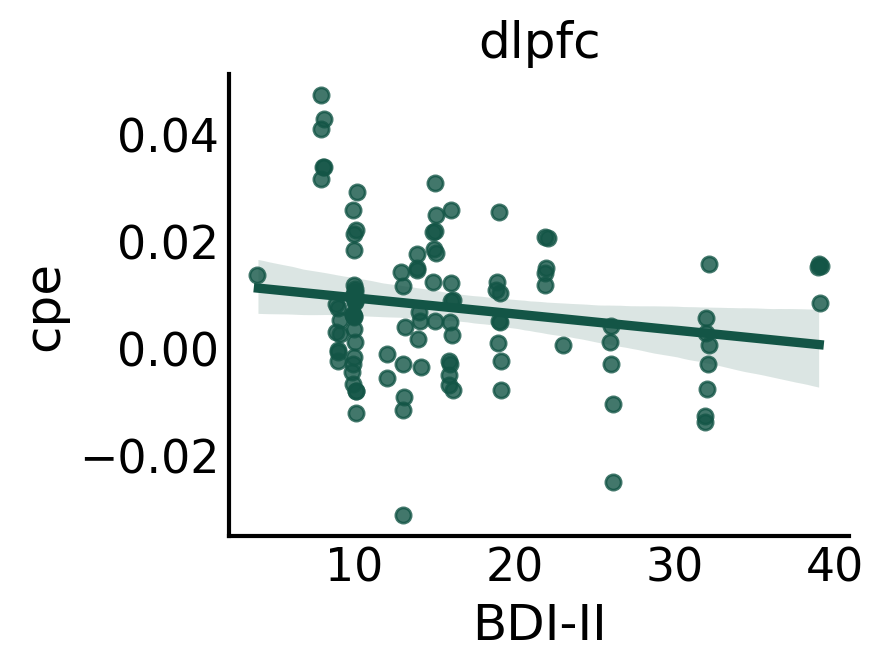

In [69]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in roi_fit_results.roi.unique().tolist():
    
    roi_temp_data = roi_fit_results[roi_fit_results.roi==roi]

#     rho   = rho_data[rho_data.roi == roi].round_rho.values[0]
#     rho_p = rho_data[rho_data.roi == roi].round_p.values[0]
    
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=200)

    sns.regplot(data=roi_temp_data,x='bdi',y='cpe',scatter=True,ci=95,
                fit_reg=True,color = '#135546',x_jitter = 0.15,scatter_kws={'s':30}) #034975
    
#     sns.scatterplot(data = roi_temp_data.groupby(['subj_id']).agg('mean'),x='bdi',
#                     y='decisionCPE',color = '#00467e',edgecolor=None,alpha=0.8)
    
#     plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    plt.xlabel('BDI-II')
#     plt.xlim([0,40])
    
    plt.tick_params(length=0) 
#     plt.ylabel('beta'+r'$beta_{{{zpow}}}$'+' cpe encoding')
#     plt.ylabel(fr'${band}_{{{zpow}}} \sim cpe$')

#     plt.text(np.max(roi_temp_data.bdi)-8,
#              np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean').elec_bCPE),3)-0.003,
#              r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',color='k',fontsize=12)
#              color='#00467e',fontsize=16)
#     plt.text(0.8,0.8,r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',
#             verticalalignment='top', horizontalalignment='right',
#             color='k',fontsize=16)

    plt.title(f'{roi}')
    sns.despine()
#     plt.tight_layout()


    
#     sns.despine()
    
    plt.savefig(f'{fig_dir}/{roi}_{rho}_{rho_p}_roi_bdi_beta-cpe-slope.pdf', format='pdf', metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=300,
        facecolor='auto', edgecolor='auto',
        backend=None)
    

In [89]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in roi_fit_results.roi.unique().tolist():
    roi_df = roi_fit_results[roi_fit_results.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.cpe.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())




acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 15 Sep 2024                                         
Time:                        22:17:46                                         
No. Iterations:                    15                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.6275      0.526     31.599     

In [56]:
# plot_roi_model_results(roi_fit_results,'roi','decisionCPE',bar_order=sig_rois,color='#135546')


# # plot ROI beta distribution
# sns.histplot(roi_fit_results[roi_fit_results.roi == 'acc'].decisionCPE)
# n = len(roi_fit_results[roi_fit_results.roi == 'acc'].decisionCPE)
# plt.title(f'ACC n={n}')
# sns.despine()


In [88]:
# plot_roi_model_results(fe_results,'roi',"bdi:decisionCPE",bar_order=bar_order,figsize=(12,6),color='#135546')
# add to slides 
